In [2]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os
import csv

from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    density_matrix as DM,
    ket as ket,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)
from Scripts import simulation_CLI as cleo
from Scripts import hdf5merge


In [3]:
import matplotlib.animation as animation
import h5py
import networkx as nx
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from scipy import signal
from scipy.stats import entropy
import pandas as pd
import umap
from tqdm.notebook import tqdm
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import cdist
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import QhullError
from matplotlib import cm, gridspec
import warnings
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
dataset_label = "mimic" #should come from this set {therm,inhomov1,inhomov2,inhomov1}
num=12 # the number of qubits in the network
num_seeds=100 # the number of seeds
steps=499 # the number of steps in any one evolution
denom = 15 # the angle denominator chosen for Haar Q unitary eg pi/15 then denom =15

In [11]:
hdf5merge.merge_hdf5_files("../data/mimic_12_disorder")
newdata3_disorder = dict(h5py.File("../data/mimic_12_disorder/mimic_12_disorder.hdf5"))

In [5]:
#Code to extract the population and the two qubit density matrices from the hdf5 data
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [11]:
#Example for how to load the data and then extract the populaitons
hdf5merge.merge_hdf5_files("../data/random")
pops_random_c2_pure = get_pops(newdata1_pure, num, "c2_2local", "random")

In [12]:
#Code to generate the ensemble average population from the 100 qubit trajectories of 500 steps each.
#The ensemble average will average over the trials per time step per qubit
def ensemble_averaged_one_point_measures_mean_std(datasets):
    # Assuming datasets is a list of 100 datasets, where each dataset is a 2D array of shape (100, N)
    # Stack datasets into a 3D array
    stacked_data = np.stack(datasets)  # Shape (100, 100, N)

    # Take the ensemble average along the first axis (averaging over all datasets)
    ensemble_average = np.mean(stacked_data, axis=0)  # Shape (100, N)

    # Calculate the standard deviation along the first axis
    ensemble_std = np.std(stacked_data, axis=0) 
    return (ensemble_average, ensemble_std)

#Example for how to use the code:
pops_random_c2_th_ens_avg = ensemble_averaged_one_point_measures_mean_std(pops_random_c2_th)

In [ ]:
n=11
data_10_steps = {
   'R1': {
        'CS1': [trial[:n] for trial in pops_random_c2_th],
        'CS2': [trial[:n] for trial in pops_random_c2_v1],
        'CS3': [trial[:n] for trial in pops_random_c2_v2],
        'CSP': [trial[:n] for trial in pops_random_c2_pure]
    },
    'R2': {
        'CS1': [trial[:n] for trial in pops_greedy_c2_th],
        'CS2': [trial[:n] for trial in pops_greedy_c2_v1],
        'CS3': [trial[:n] for trial in pops_greedy_c2_v2],
        'CSP': [trial[:n] for trial in pops_greedy_c2_pure]        
    },
    'R3': {
        'CS1': [trial[:n] for trial in pops_landmax_c2_th],
        'CS2': [trial[:n] for trial in pops_landmax_c2_v1],
        'CS3': [trial[:n] for trial in pops_landmax_c2_v2],
        'CSP': [trial[:n] for trial in pops_landmax_c2_pure] 
    },
    'R4': {
        'CS1': [trial[:n] for trial in pops_strongmax_c2_th],
        'CS2': [trial[:n] for trial in pops_strongmax_c2_v1],
        'CS3': [trial[:n] for trial in pops_strongmax_c2_v2],
        'CSP': [trial[:n] for trial in pops_strongmax_c2_pure]
    },
    'R5': {
        'CS1': [trial[:n] for trial in pops_mimic_c2_th],
        'CS2': [trial[:n] for trial in pops_mimic_c2_v1],
        'CS3': [trial[:n] for trial in pops_mimic_c2_v2],
        'CSP': [trial[:n] for trial in pops_mimic_c2_pure] 
    }
    # Add more rules as needed
}

n=11
data_ens_avg = {
        'R1': {
            'CS1': pops_random_c2_th_ens_avg[0][n:],
            'CS2': pops_random_c2_v1_ens_avg[0][n:],
            'CS3': pops_random_c2_v2_ens_avg[0][n:],
            'CSP': pops_random_c2_pure_ens_avg[0][n:]
            },
        'R2': {
            'CS1': pops_greedy_c2_th_ens_avg[0][n:],
            'CS2': pops_greedy_c2_v1_ens_avg[0][n:],
            'CS3': pops_greedy_c2_v2_ens_avg[0][n:],  
            'CSP': pops_greedy_c2_pure_ens_avg[0][n:]},
         'R3': {
            'CS1': pops_landmax_c2_th_ens_avg[0][n:],
            'CS2': pops_landmax_c2_v1_ens_avg[0][n:],
            'CS3': pops_landmax_c2_v2_ens_avg[0][n:],
             'CSP': pops_landmax_c2_pure_ens_avg[0][n:]},
         'R4': {
            'CS1': pops_strongmax_c2_th_ens_avg[0][n:],
            'CS2': pops_strongmax_c2_v1_ens_avg[0][n:],
            'CS3': pops_strongmax_c2_v2_ens_avg[0][n:],
         'CSP': pops_strongmax_c2_pure_ens_avg[0][n:]},
         'R5': {
            'CS1': pops_mimic_c2_th_ens_avg[0][n:],
            'CS2': pops_mimic_c2_v1_ens_avg[0][n:],
            'CS3': pops_mimic_c2_v2_ens_avg[0][n:],
         'CSP': pops_mimic_c2_pure_ens_avg[0][n:]}
        # Add more rules as needed
            }



In [ ]:
#Code to preprocess the data so that it can be appropriately used for PCA and Convex Hull volume calc
def preprocess_data(data_dict, structure='time_first'):

    processed_data = {}
    
    for rule, ic_dict in data_dict.items():
        processed_data[rule] = {}
        
        for ic, trials in ic_dict.items():
            # Convert list of trials to numpy array if needed
            if not isinstance(trials, np.ndarray):
                trials = np.array(trials)
            
            n_trials = len(trials)
            
            if structure == 'qubit_first':  # (n_qubits, time_steps)
                # Transpose each trial to have time steps first
                trials = np.array([trial.T for trial in trials])  # Now (n_trials, time_steps, n_qubits)
            
            time_steps, n_qubits = trials[0].shape
            
            # Reshape to (n_trials * time_steps, n_qubits)
            processed_data[rule][ic] = trials.reshape(n_trials * time_steps, n_qubits)
    
    return processed_data

In [ ]:
#Code to calculate the relative entropy of the qubit from the thermal state associated with U(1) conservation
#Note that the code uses natural log so be mindful of scaling for log2 or log10
def rel_diff_from_thermal(therm_state, state, N):
    """Compute KL divergence from thermal state."""
    # Compute the uniform reference probability
    pop_ref = np.sum(therm_state) / N
    
    # Calculate KL divergence terms
    kl_terms = []
    for p in state:
        # KL for binary distribution: p log(p/q) + (1-p)log((1-p)/(1-q))
        term = 0
        if 0 < p < 1 and 0 < pop_ref < 1:
            term += p * np.log(p / pop_ref) 
            term += (1 - p) * np.log((1 - p) / (1 - pop_ref))
        kl_terms.append(term)
    
    return np.sum(kl_terms)


#Code to calculate the trace distance of the qubit from the thermal state associated with U(1) conservation
def rel_trace_dist_across_ics(data_dict,rule='R1',N=12):
    aggregated_relative_entropy={}
    for ic, data in data_dict[rule].items():
        aggregated_relative_entropy[ic] = []
        n_time_steps=len(data[0])
    
    # Loop over time steps
        for t in range(n_time_steps):
            data=np.array(data)
            pops_at_t = data[:, t, :]  # Populations across all simulations at time step t
            
            # Compute relative entropy (mean over all simulations)
            reference_p = ((N-1) * 0.1 + 0.4) / N
            relative_entropy = (0.5*np.abs(pops_at_t - reference_p)).sum(axis=1)
            aggregated_relative_entropy[ic].append(np.mean(relative_entropy))
        
    plt.figure(figsize=(12, 6))
    colors = cm.tab10(np.linspace(0, 1, len(aggregated_relative_entropy)))

    for i, (ic, rel_ent) in enumerate(aggregated_relative_entropy.items()):
            plt.plot(range(len(rel_ent)), rel_ent, 'o-', color=colors[i], label=f'IC: {ic}')
    

    plt.title("Aggregated Trace distance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Trace distance")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [193]:
#Uncentered PCA code
def manual_uncentered_pca(data):
    """
    Perform uncentered PCA manually.
    
    Parameters:
    -----------
    data : ndarray
        Data matrix of shape (n_samples, n_features)
    
    Returns:
    --------
    eigenvalues : ndarray
        Eigenvalues in descending order
    eigenvectors : ndarray
        Eigenvectors corresponding to eigenvalues
    projections : ndarray
        Data projected onto eigenvectors
    explained_variance_ratio : ndarray
        Ratio of explained variance for each component
    """
    # Compute covariance matrix without centering
    cov_matrix = data.T @ data / (data.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Project data onto eigenvectors
    projections = data @ eigenvectors
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    return eigenvalues, eigenvectors, projections, explained_variance_ratio

#code to generate convex hull volume. The robust volume code puts a small jitterinf for overlapping points                
def calculate_robust_volume(points, percentile=95):
    """
    Calculate a robust estimate of the convex hull volume by:
    1. Removing outliers based on percentile
    2. Computing the convex hull volume if enough points remain
    
    Parameters:
    -----------
    points : ndarray
        Points in n-dimensional space
    percentile : float
        Percentile threshold for outlier removal
    
    Returns:
    --------
    volume : float
        Robust estimate of convex hull volume
    """
    from scipy.spatial import ConvexHull
    
    if len(points) < 4:
        return 0.0
    
    try:
        # Calculate distances from centroid
        centroid = np.mean(points, axis=0)
        distances = np.sqrt(np.sum((points - centroid)**2, axis=1))
        
        # Determine threshold for outlier removal
        threshold = np.percentile(distances, percentile)
        
        # Remove outliers
        filtered_points = points[distances <= threshold]
        
        # Calculate convex hull volume if enough points remain
        if len(filtered_points) >= 4:
            hull = ConvexHull(filtered_points)
            return hull.volume
        else:
            return 0.0
    except Exception as e:
        print(f"Error in volume calculation: {e}")
        return 0.0


In [ ]:
#Code to generate the convex hull volume per rule for all ICs
#The code also generates the average relative entorpy from the thermal state
#and the average trace distance from thermal state
#The code uses uncentered PCA which is crucial. If you want to use normal PCA, change code 
def plot_pca_with_volume_and_entropy_all_rules_per_ic(data_dict, ics, rules, N=12, n_components=3, structure='time_first', fig_name="all_ics_analysis.png"):
    """
    Each row corresponds to a different IC.
    """
    # Specific colors for rules
    colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    rule_colors = {rule: colors[i % len(colors)] for i, rule in enumerate(rules)}
    
    # Preprocess data with the provided function
    processed_data = preprocess_data(data_dict, structure)
    
    # Filter out ICs that don't have enough rules
    available_ics = []
    for ic in ics:
        available_rules = [rule for rule in rules if ic in data_dict.get(rule, {})]
        if len(available_rules) >= 2:
            available_ics.append(ic)
        else:
            print(f"Skipping IC {ic}: not available in enough rules")
    
    if not available_ics:
        print("No ICs available in enough rules to plot.")
        return
    
    # Create a figure with 3 columns (for volume, entropy, and trace distance)
    # and one row per IC
    n_rows = len(available_ics)
    fig = plt.figure(figsize=(15, 4 * n_rows))
    gs = gridspec.GridSpec(n_rows, 3)
    
    # IC name mapping for better labels
    ic_to_name = {'CS1': 'CS1', 'CS2': 'CS2', 'CS3': 'CS3', 'CSP': 'Pure State'}
    
    # Process each IC
    for row_idx, ic in enumerate(available_ics):
        # Extract raw data for time steps and trials info
        available_rules = [rule for rule in rules if ic in data_dict.get(rule, {})]
        n_time_steps = None
        raw_data_by_rule = {}
        
        for rule in available_rules:
            raw_data = data_dict[rule][ic]
            raw_data_by_rule[rule] = np.array(raw_data)
            if n_time_steps is None:
                n_time_steps = len(raw_data[0])
        
        # Combine data from all rules for PCA fitting
        combined_data = np.vstack([processed_data[rule][ic] for rule in available_rules])
        
        # Apply manual uncentered PCA
        eigenvalues, eigenvectors, combined_projections, explained_variance_ratio = manual_uncentered_pca(combined_data)
        
        # Find how many components needed for 90% variance
        cumulative_variance = np.cumsum(explained_variance_ratio)
        n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
        print(f"IC {ic}: Components needed for 90% variance: {n_components_90}")
        
        # Get projections with the required number of components
        combined_projections_high_dim = combined_data @ eigenvectors[:, :n_components_90]
        
        # Split projections back by rule
        rule_projections_high_dim = {}
        start_idx = 0
        
        for rule in available_rules:
            rule_data_size = processed_data[rule][ic].shape[0]
            end_idx = start_idx + rule_data_size
            
            rule_projections_high_dim[rule] = combined_projections_high_dim[start_idx:end_idx]
            
            start_idx = end_idx
        
        #Convex Hull Volume using higher-dimensional PCA
        ax1 = fig.add_subplot(gs[row_idx, 0])
        hull_volumes = {}
        
        for rule in available_rules:
            # Use the higher-dimensional projections for volume calculation
            proj = rule_projections_high_dim[rule]
            n_trials = len(raw_data_by_rule[rule])
            
            # Calculate convex hull volumes for each time step
            volumes = []
            for t in range(n_time_steps):
                # Get all points at time step t across trials
                time_points = []
                for trial in range(n_trials):
                    time_idx = trial * n_time_steps + t
                    if time_idx < len(proj):
                        time_points.append(proj[time_idx])
                
                time_points = np.array(time_points)
                
                # Use the robust volume calculation
                volume = calculate_robust_volume(time_points)
                volumes.append(volume)
            
            hull_volumes[rule] = volumes

            # Calculate and plot time-averaged volume (moving average with window size 10)
            window_size = 10
            avg_volumes = np.convolve(volumes, np.ones(window_size)/window_size, mode='valid')
            pad_size = len(volumes) - len(avg_volumes)
            avg_volumes = np.pad(avg_volumes, (pad_size//2, pad_size - pad_size//2), 'edge')
            ax1.plot(range(len(avg_volumes)), avg_volumes, ':', color=rule_colors[rule], 
                    linewidth=1.5, alpha=0.9, label=f'Rule: {rule} (avg)')
        
        ax1.set_xlabel(r'$\ell$', fontsize=15)
        ax1.set_ylabel(r'$V_{CH}$'f'({n_components_90}D)', fontsize=16)
        ax1.set_title(f'{ic_to_name.get(ic, ic)}', fontsize=16)
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Relative Entropy per Rule
        ax2 = fig.add_subplot(gs[row_idx, 1])

        for rule in available_rules:
            # Calculate relative entropy for each time step
            rel_entropy = []
            
            for t in range(n_time_steps):
                pops_at_t = raw_data_by_rule[rule][:, t, :]  # Populations across all simulations at time t
                reference_p = mp.sum(pops_at_t) / N
                
                # Vectorized calculation of KL divergence (relative entropy)
                # Avoid log(0) errors with small epsilon
                epsilon = 1e-10
                p_safe = np.clip(pops_at_t, epsilon, 1-epsilon)
                ref_p_safe = np.clip(reference_p, epsilon, 1-epsilon)
                
                # Calculate KL divergence: p*log(p/q) + (1-p)*log((1-p)/(1-q))
                kl_div = p_safe * np.log(p_safe / ref_p_safe) + (1 - p_safe) * np.log((1 - p_safe) / (1 - ref_p_safe))
                mean_kl = np.mean(np.sum(kl_div, axis=1))
                rel_entropy.append(mean_kl)
            
            # Plot raw entropy data with low alpha
            ax2.plot(range(len(rel_entropy)), rel_entropy, '-', color=rule_colors[rule], 
                    linewidth=1.5, alpha=0.3, label=f'Rule: {rule}')
            
            # Calculate and plot time-averaged entropy
            window_size = 5
            avg_entropy = np.convolve(rel_entropy, np.ones(window_size)/window_size, mode='valid')
            pad_size = len(rel_entropy) - len(avg_entropy)
            avg_entropy = np.pad(avg_entropy, (pad_size//2, pad_size - pad_size//2), 'edge')
            ax2.plot(range(len(avg_entropy)), avg_entropy, ':', color=rule_colors[rule], 
                    linewidth=1.5, alpha=0.9, label=f'Rule: {rule} (avg)')
        
        ax2.set_xlabel(r'$\ell$', fontsize=15)
        ax2.set_ylabel(r'$\mathcal{D}(\{ \rho_{q}(0)\},\bar{\rho})$', fontsize=16)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # TD per Rule
        ax3 = fig.add_subplot(gs[row_idx, 2])
        
        for rule in available_rules:
            # Calculate trace distance for each time step
            td = []
            
            for t in range(n_time_steps):
                pops_at_t = raw_data_by_rule[rule][:, t, :]  # Populations across all simulations at time t
                reference_p = np.sum(pops_at_t) / N
                td_t = (0.5*np.abs(pops_at_t - reference_p)).sum(axis=1)
                td.append(np.mean(td_t))  # Append inside the time step loop
            
            # Plot raw trace distance data with low alpha
            ax3.plot(range(len(td)), td, '-o', color=rule_colors[rule], 
                    linewidth=1.5, markersize=3, alpha=0.3, label=f'Rule: {rule}')
                    
            # Calculate and plot time-averaged trace distance
            window_size = 5
            avg_td = np.convolve(td, np.ones(window_size)/window_size, mode='valid')
            pad_size = len(td) - len(avg_td)  # Add padding to match original length
            avg_td = np.pad(avg_td, (pad_size//2, pad_size - pad_size//2), 'edge')
            ax3.plot(range(len(avg_td)), avg_td, ':', color=rule_colors[rule], 
                    linewidth=1.5, alpha=0.9, label=f'Rule: {rule} (avg)')
        
        ax3.set_xlabel(r'$\ell$', fontsize=15)
        ax3.set_ylabel(r'$\frac{1}{2}\sum_{q=1} ^N |p_q - \bar{p}| $', fontsize=16)
        ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Create a single legend for the entire figure
    legend_entries = []
    for rule in rules:
        if any(rule in data_dict.get(rule, {}) for ic in available_ics):
            # Add entries for raw data
            legend_entries.append(plt.Line2D([0], [0], color=rule_colors[rule], lw=1.5, alpha=0.3, label=f'Rule: {rule}'))
            # Add entries for time-averaged data
            legend_entries.append(plt.Line2D([0], [0], color=rule_colors[rule], lw=2.5, linestyle=':', alpha=0.9, label=f'Rule: {rule} (avg)'))
    
    # Add the legend at the bottom of the figure
    fig.legend(handles=legend_entries, loc='lower center', bbox_to_anchor=(0.5, 0), 
               ncol=len(rules), fontsize=12)
    
    # Add space at the bottom for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    
    #uncomment if you want to save the figure
    #plt.savefig("rel_ent_hull_volume_trace_per_IC_all_rules.png", dpi=300, bbox_inches='tight')
    
    return fig

IC CS1, Rule R1: Components needed for 80% variance: 2
IC CS2, Rule R1: Components needed for 80% variance: 2
IC CS3, Rule R1: Components needed for 80% variance: 2
IC CSP, Rule R1: Components needed for 80% variance: 4
IC CS1, Rule R2: Components needed for 80% variance: 2
IC CS2, Rule R2: Components needed for 80% variance: 2
IC CS3, Rule R2: Components needed for 80% variance: 2
IC CSP, Rule R2: Components needed for 80% variance: 4
IC CS1, Rule R3: Components needed for 80% variance: 2
IC CS2, Rule R3: Components needed for 80% variance: 2
IC CS3, Rule R3: Components needed for 80% variance: 2
IC CSP, Rule R3: Components needed for 80% variance: 4
IC CS1, Rule R4: Components needed for 80% variance: 2
IC CS2, Rule R4: Components needed for 80% variance: 2
IC CS3, Rule R4: Components needed for 80% variance: 2
IC CSP, Rule R4: Components needed for 80% variance: 4
IC CS1, Rule R5: Components needed for 80% variance: 2
IC CS2, Rule R5: Components needed for 80% variance: 2
IC CS3, Ru

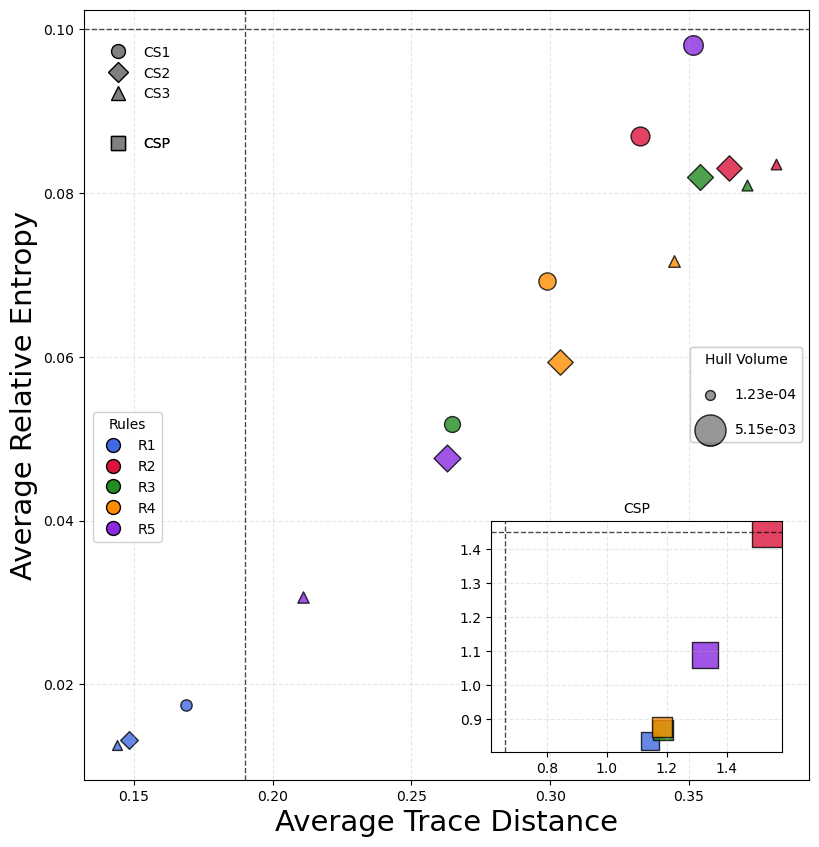

In [485]:
#Code to extract late-time metrics for each rule and IC. It returns a list of dictionaries 
#with KL divergence, trace distance, and hull volume.
def extract_late_time_metrics(data_dict, ics, rules, N=12, n_components=3, structure='time_first', late_time_fraction=0.25):
    """
    Parameters:
    -----------
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    ics : list
        List of initial conditions to analyze
    rules : list
        List of rules to analyze
    N : int
        Number of states in the system
    n_components : int
        Number of PCA components to use
    structure : str
        'time_first' or 'trial_first' for data organization
    late_time_fraction : float
        Fraction of time steps to consider as late time (from the end)
        
    Returns:
    --------
    late_time_metrics : list
        List of dictionaries, one per rule, each containing KL divergence, trace distance, 
        and hull volume for each IC
    """
    
    # Preprocess data with the provided function
    processed_data = preprocess_data(data_dict, structure)
    
    # Filter out ICs that don't have enough rules
    available_ics = []
    for ic in ics:
        available_rules = [rule for rule in rules if ic in data_dict.get(rule, {})]
        if len(available_rules) >= 2:
            available_ics.append(ic)
        else:
            print(f"Skipping IC {ic}: not available in enough rules")
    
    if not available_ics:
        print("No ICs available in enough rules to plot.")
        return []
    
    # List to store metrics for each rule
    late_time_metrics = []
    
    # Process each rule
    for rule_idx, rule in enumerate(rules):
        if rule not in data_dict:
            print(f"Rule {rule} not in data dictionary. Skipping.")
            continue
            
        # Initialize dictionaries for this rule's metrics
        hull_volumes = {}
        kl_divergence = {}
        trace_distance = {}
        
        # Process each IC
        for ic in available_ics:
            if ic not in data_dict[rule]:
                print(f"IC {ic} not available for rule {rule}. Skipping.")
                continue
                
            # Extract raw data
            raw_data = np.array(data_dict[rule][ic])
            
            if structure == 'time_first':
                # Data is (trials, time_steps, variables)
                n_trials, n_time_steps, n_vars = raw_data.shape
            else:  # 'trial_first'
                # Data is (time_steps, trials, variables)
                n_time_steps, n_trials, n_vars = raw_data.shape
                # Transpose to (trials, time_steps, variables)
                raw_data = raw_data.transpose(1, 0, 2)
            
            # Combine data from all rules for this IC for PCA fitting
            available_rules = [r for r in rules if ic in data_dict.get(r, {})]
            combined_data = np.vstack([processed_data[r][ic] for r in available_rules])
            
            # Apply manual uncentered PCA
            eigenvalues, eigenvectors, combined_projections, explained_variance_ratio = manual_uncentered_pca(combined_data)
            
            # Find how many components needed for 90% variance
            cumulative_variance = np.cumsum(explained_variance_ratio)
            n_components_90 = np.argmax(cumulative_variance >= 0.5) + 2
            print(f"IC {ic}, Rule {rule}: Components needed for 80% variance: {n_components_90}")
            
            # Get projections for this rule with the required number of components
            rule_data = processed_data[rule][ic]
            projections = rule_data @ eigenvectors[:, :n_components_90]
            
            # Calculate the number of time steps considered "late time"
            late_time_steps = int(n_time_steps * late_time_fraction)
            
            # Calculate metrics for late time only
            # 1. Calculate convex hull volume
            late_time_volumes = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                # Get all points at time step t across trials
                time_points = []
                for trial in range(n_trials):
                    time_idx = trial * n_time_steps + t
                    if time_idx < len(projections):
                        time_points.append(projections[time_idx])
                
                time_points = np.array(time_points)
                volume = calculate_robust_volume(time_points)
                late_time_volumes.append(volume)
            
            # Average volume over late time
            hull_volumes[ic] = np.mean(late_time_volumes)
            
            # 2. Calculate KL divergence (relative entropy)
            late_time_rel_entropy = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                pops_at_t = raw_data[:, t, :]  # Populations across all simulations at time t
                reference_p = ((N-1) * 0.1 + 0.4) / N
                
                # Vectorized calculation of KL divergence (relative entropy)
                # Avoid log(0) errors with small epsilon
                epsilon = 1e-10
                p_safe = np.clip(pops_at_t, epsilon, 1-epsilon)
                ref_p_safe = np.clip(reference_p, epsilon, 1-epsilon)
                
                # Calculate KL divergence: p*log(p/q) + (1-p)*log((1-p)/(1-q))
                kl_div = p_safe * np.log(p_safe / ref_p_safe) + (1 - p_safe) * np.log((1 - p_safe) / (1 - ref_p_safe))
                mean_kl = np.mean(np.sum(kl_div, axis=1))
                late_time_rel_entropy.append(mean_kl)
            
            # Average KL divergence over late time
            kl_divergence[ic] = np.mean(late_time_rel_entropy)
            
            # 3. Calculate trace distance
            late_time_td = []
            for t in range(n_time_steps - late_time_steps, n_time_steps):
                pops_at_t = raw_data[:, t, :]  # Populations across all simulations at time t
                reference_p = ((N-1) * 0.1 + 0.4) / N
                td_t = np.abs(pops_at_t - reference_p).sum(axis=1)
                late_time_td.append(np.mean(td_t))
            
            # Average trace distance over late time
            trace_distance[ic] = np.mean(late_time_td)
        
        # Store all metrics for this rule
        rule_metrics = {
            'rule': rule,
            'hull_volumes': hull_volumes,
            'kl_divergence': kl_divergence,
            'trace_distance': trace_distance
        }
        
        late_time_metrics.append(rule_metrics)
    
    return late_time_metrics

def plot_kl_vs_trace_scatter(late_time_means, rules, inset_ics=None):
    """
    Create a scatter plot with KL divergence on y-axis, trace distance on x-axis,
    and convex hull volume represented by marker size, with an inset for CSP data.
    
    Parameters:
    -----------
    late_time_means : list
        List of dictionaries containing metrics for each rule
    rules : list
        List of rule names corresponding to the late_time_means
    inset_ics : list
        List of initial conditions to be plotted in an inset
    """
    
    # Set up colors for each rule
    rule_colors = {
        'R1': '#4169E1',   # Blue
        'R2': '#DC143C',   # Orange
        'R3': '#228B22',   # Green
        'R4': '#FF8C00',   # Red
        'R5': '#8A2BE2'    # Purple
    }
    
    # Set up markers for each IC - using the actual IC keys from your data
    ic_markers = {
        'CS1': 'o',      # Circle
        'CS2': 'D',      # Diamond
        'CS3': '^',      # Triangle
        'CSP': 's'       # Square
    }
    
    # Create a figure with a larger right margin to accommodate the legend
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.subplots_adjust(right=0.8)  # Make space on the right for the legend
    
    # Find the min and max hull volumes to scale marker sizes appropriately
    min_hull = float('inf')
    max_hull = float('-inf')
    
    # First, determine what ICs are actually in the data
    all_ics = set()
    for rule_means in late_time_means:
        hull_volumes = rule_means['hull_volumes']
        for ic in hull_volumes.keys():
            all_ics.add(ic)
    
    print(f"Found these ICs in data: {all_ics}")
    
    # Find min and max hull volumes
    for rule_means in late_time_means:
        hull_volumes = rule_means['hull_volumes']
        for ic, value in hull_volumes.items():
            # Convert numpy float to Python float if needed
            if hasattr(value, 'item'):
                value = value.item()
            min_hull = min(min_hull, value)
            max_hull = max(max_hull, value)
    
    print(f"Hull volume range: {min_hull} to {max_hull}")
    
    # Size scaling function
    def scale_size(hull_volume):
        # Convert numpy float to Python float if needed
        if hasattr(hull_volume, 'item'):
            hull_volume = hull_volume.item()
            
        # Scale between 50 and 500 for better visibility
        min_size = 50
        max_size = 500
        # Add a small value to avoid division by zero
        if max_hull == min_hull:
            return (min_size + max_size) / 2
        return min_size + (hull_volume - min_hull) / (max_hull - min_hull) * (max_size - min_size)
    
    # Track handles for legend
    rule_handles = []
    rule_labels = []
    ic_handles = []
    ic_labels = []
    inset_ic_handles = []
    inset_ic_labels = []
    
    # Create an inset axes for the CSP data
    if inset_ics:
        axins = inset_axes(ax, width="40%", height="30%", loc="lower right", borderpad=2)

    
    # Create the scatter plot for each rule and IC
    for i, (rule_means, rule) in enumerate(zip(late_time_means, rules)):
        hull_volumes = rule_means['hull_volumes']
        kl_divergence = rule_means['kl_divergence']
        trace_distance = rule_means['trace_distance']
        
        for ic in hull_volumes.keys():
            if ic in kl_divergence and ic in trace_distance:
                # Calculate marker size based on hull volume
                size = scale_size(hull_volumes[ic])
                
                # Get marker for this IC
                marker = ic_markers.get(ic, 'o')  # Default to circle if not found
                
                # Determine whether to plot in main axes or inset
                target_ax = axins if inset_ics and ic in inset_ics else ax
                
                # Plot point
                point = target_ax.scatter(
                    trace_distance[ic],  # x-axis: trace distance
                    kl_divergence[ic],   # y-axis: KL divergence
                    s=size,              # size: hull volume
                    color=rule_colors.get(rule, 'black'),
                    marker=marker,
                    alpha=0.8,
                    edgecolors='black',
                    linewidth=1,
                    label=f'{rule}, {ic}'
                )
                
                # Track handles for custom legend
                if inset_ics and ic in inset_ics:
                    # For inset legend
                    if ic not in inset_ic_labels:
                        inset_ic_handles.append(plt.Line2D([0], [0], color='gray', marker=marker, 
                                                 linestyle='', markersize=10, markeredgecolor='black'))
                        inset_ic_labels.append(ic)
                elif ic not in ic_labels:
                    # For main plot legend
                    ic_handles.append(plt.Line2D([0], [0], color='gray', marker=marker, 
                                             linestyle='', markersize=10, markeredgecolor='black'))
                    ic_labels.append(ic)
                
                if rule not in rule_labels:
                    rule_handles.append(plt.Line2D([0], [0], color=rule_colors.get(rule, 'black'), marker='o', 
                                               linestyle='', markersize=10, markeredgecolor='black'))
                    rule_labels.append(rule)
    
    # Style the inset axes
    if inset_ics:
        axins.set_title("CSP", fontsize=10)
        axins.grid(True, linestyle='--', alpha=0.3)
        axins.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        axins.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    
    # Set titles and labels
    ax.set_xlabel('Average Trace Distance', fontsize=21)
    ax.set_ylabel('Average Relative Entropy', fontsize=21)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Set up formatting for axes
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    
    # Add reference lines
    ax.axvline(x=0.19, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    ax.axhline(y=0.1, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    
    if inset_ics:
        axins.axvline(x=0.66, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
        axins.axhline(y=1.45, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    
    # Create a size legend - place it directly on the plot
    size_handles = []
    size_labels = []
    size_values = [min_hull, max_hull]
    
    for val in size_values:
        size_handles.append(plt.scatter([], [], s=scale_size(val), color='gray', alpha=0.8, edgecolors='black'))
        size_labels.append(f'{val:.2e}')  # Using scientific notation for small values
        
    # Place the size legend inside the plot in the lower right corner
    # This ensures it will be visible regardless of how the figure is saved
    size_legend = ax.legend(size_handles, size_labels,
                       loc='center right',  # Position inside the plot
                       fontsize=10, title="Hull Volume", framealpha=0.9,
                       scatterpoints=1, labelspacing=1.5, ncol=1)
    ax.add_artist(size_legend)
    ax.add_artist(size_legend)
    
    # Rule legend (colors)
    if rule_handles:
        rule_legend = ax.legend(rule_handles, rule_labels,
                               loc='lower center', bbox_to_anchor=(0.06, 0.3),
                               fontsize=10, title="Rules", framealpha=0.9, ncol=1)
        ax.add_artist(rule_legend)
    
    # IC legend (markers) for main plot
    if ic_handles:
        ic_legend = ax.legend(ic_handles, ic_labels,
                             loc='upper left', bbox_to_anchor=(0.01, 0.97),
                             fontsize=10, title="", framealpha=0, ncol=1)
        ax.add_artist(ic_legend)
    
    # IC legend for inset plot
    if inset_ics and inset_ic_handles:
        inset_ic_legend = ax.legend(inset_ic_handles, inset_ic_labels,
                                   loc='lower center', bbox_to_anchor=(0.073, 0.8),
                                   fontsize=10, title="", framealpha=0, ncol=1)
        ax.add_artist(inset_ic_legend)
    
    # Adjust layout to make room for legends on the right
    plt.subplots_adjust(right=0.85)
    
    # Remove tight_layout() call as it conflicts with manually set margins
    
    # Save the figure - remove bbox_inches parameter which might be causing issues
    plt.savefig("kl_vs_trace_scatter_with_inset.png", dpi=300)
    
    return fig
    
# Example of how to update the run_full_analysis function
def run_full_analysis(data_dict, ics, rules, inset_ics=None, N=12, structure='time_first'):
    """
    Run the full analysis pipeline:
    1. Extract late time metrics
    2. Create and save the scatter plot with inset
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    ics : list
        List of initial conditions to analyze
    rules : list
        List of rules to analyze
    inset_ics : list
        List of initial conditions to plot in inset
    N : int
        Number of states in the system
    structure : str
        'time_first' or 'trial_first' for data organization
    
    Returns:
    --------
    fig : Figure
        The generated scatter plot figure
    """
    # Extract late time metrics for main ICs
    late_time_metrics = extract_late_time_metrics(
        data_dict, ics + (inset_ics if inset_ics else []), rules, N=N, structure=structure, late_time_fraction=0.25
    )
    
    # Create and save scatter plot with inset
    fig = plot_kl_vs_trace_scatter(late_time_metrics, rules, inset_ics)
    
    return fig, late_time_metrics

In [ ]:
#examples for how to run the above functions to generate scatter plot of KL, TD and CH
ics = ['CS1', 'CS2', 'CS3']
inset_ics = ['CSP']
rules = ['R1', 'R2', 'R3', 'R4', 'R5']
fig, metrics = run_full_analysis(data, ics, rules, inset_ics, N=12, structure='time_first')

IC CS1: Components needed for 90% variance: 1
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume calculation: Need at least 2-D data
Error in volume ca

KeyboardInterrupt: 

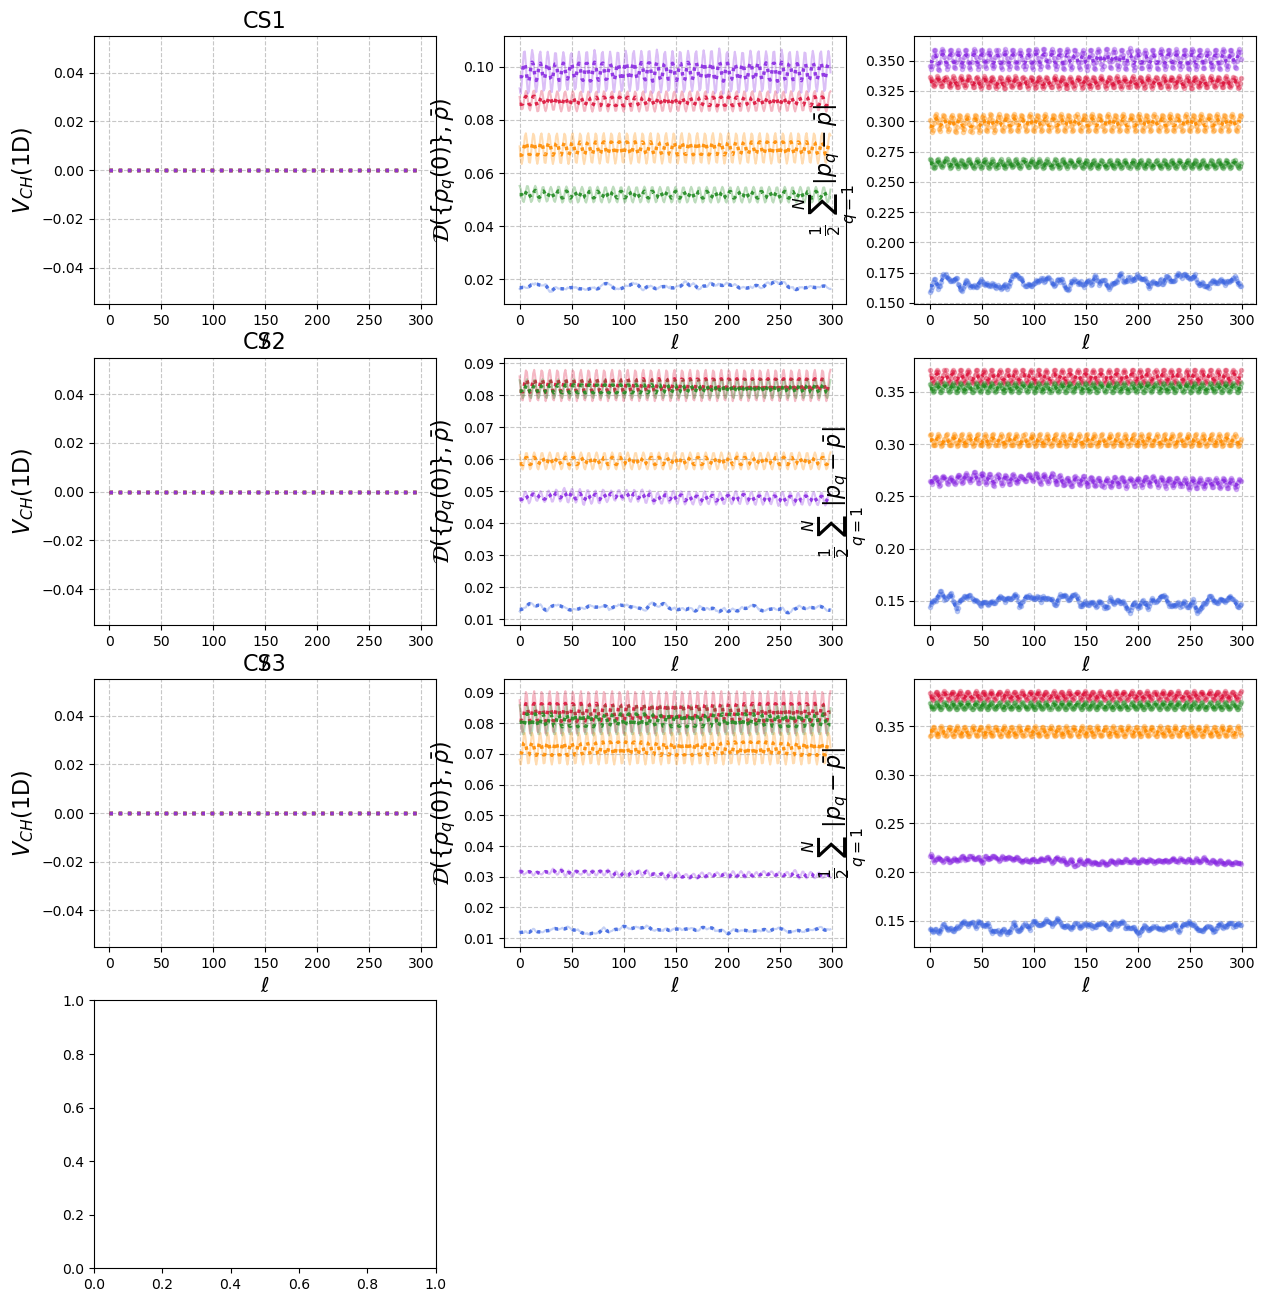

In [341]:
#example for how to run the code that generates the CH,TD,KL as a function of time 
ics = ["CS1","CS2","CS3","CSP"]  # List of IC indices to analyze
rules = ['R1', 'R2', 'R3', 'R4', 'R5']  # List of rules to compare
plot_pca_with_volume_and_entropy_all_rules_per_ic(data, ics, rules)

IC CS1, Rule R1: Components needed for 80% variance: 2
IC CS2, Rule R1: Components needed for 80% variance: 2
IC CS3, Rule R1: Components needed for 80% variance: 2
IC CSP, Rule R1: Components needed for 80% variance: 4
IC CS1, Rule R2: Components needed for 80% variance: 2
IC CS2, Rule R2: Components needed for 80% variance: 2
IC CS3, Rule R2: Components needed for 80% variance: 2
IC CSP, Rule R2: Components needed for 80% variance: 4
IC CS1, Rule R3: Components needed for 80% variance: 2
IC CS2, Rule R3: Components needed for 80% variance: 2
IC CS3, Rule R3: Components needed for 80% variance: 2
IC CSP, Rule R3: Components needed for 80% variance: 4
IC CS1, Rule R4: Components needed for 80% variance: 2
IC CS2, Rule R4: Components needed for 80% variance: 2
IC CS3, Rule R4: Components needed for 80% variance: 2
IC CSP, Rule R4: Components needed for 80% variance: 4
IC CS1, Rule R5: Components needed for 80% variance: 2
IC CS2, Rule R5: Components needed for 80% variance: 2
IC CS3, Ru

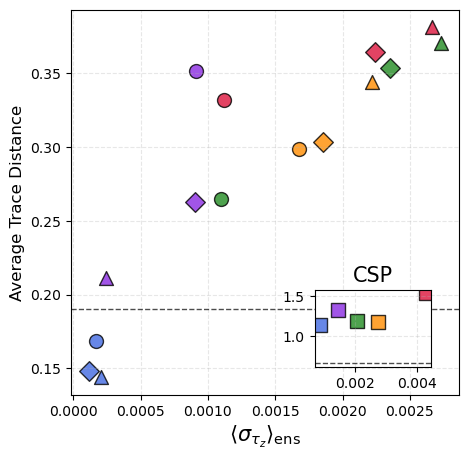

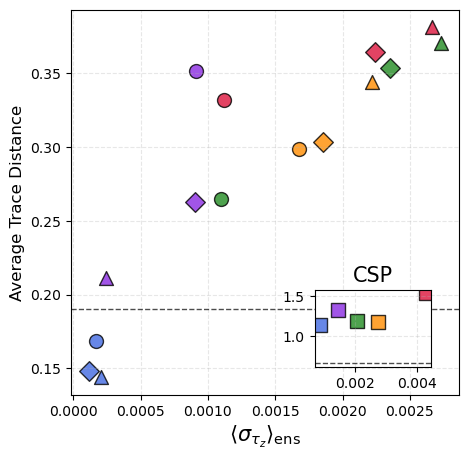

In [480]:
#Code to generate scatter plot betwren the trace distance and the shift parameter of the map.
#you can modify this function and use it to plot any other parameter with trace dist.
#You can change color and marker properties depending on number of ICS and Rules
def plot_trace_vs_tzs_scatter(data_dict, tzs, ics, rules=None, inset_ics=None, N=12, structure='time_first'):    
    """
    Parameters:
    data_dict : dict
        Dictionary of rules, each containing a dictionary of ICs, each containing raw data
    tzs: list
        List that includes the tzs late time averaged tz per rule per IC. 
    ics : list
        List of initial conditions to analyze
    rules : list
        List of rules to analyze
    inset_ics: None
        You can replace this to have some ICs insetted
    N : int
        Number of states in the system

    Returns:
        a scatter plot between average total trace distance and the tzs per rule per IC according to the given color and marker properties
    """
    
    # Set up colors for each rule
    rule_colors = {
        'R1': '#4169E1',   # Blue
        'R2': '#DC143C',   # Orange
        'R3': '#228B22',   # Green
        'R4': '#FF8C00',   # Red
        'R5': '#8A2BE2'    # Purple
    }
    
    # Set up markers for each IC
    ic_markers = {
        'CS1': 'o',      # Circle
        'CS2': 'D',      # Diamond
        'CS3': '^',      # Triangle
        'CSP': 's'       # Square
    }
    
    # If rules is not provided, use the keys from rule_colors
    if rules is None:
        rules = list(rule_colors.keys())
    
    # Create a figure with a larger right margin to accommodate the legend
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Create an inset axes if inset_ics is specified
    axins = inset_axes(ax, width="30%", height="20%", loc="lower right", borderpad=2)
    
    # Extract late time metrics
    late_time_means = extract_late_time_metrics(
        data_dict, ics + (inset_ics if inset_ics else []), rules, N=N, structure=structure, late_time_fraction=0.25
    )
    
    # First, determine what ICs are actually in the data
    all_ics = set()
    for rule_means in late_time_means:
        trace_distance = rule_means['trace_distance']
        for ic in trace_distance.keys():
            all_ics.add(ic)
    
    print(f"Found these ICs in data: {all_ics}")
    
    # Plot for each rule and IC
    for i, (rule_means, rule) in enumerate(zip(late_time_means, rules)):
        trace_distance = rule_means['trace_distance']
        
        for j, ic in enumerate(ics):
            if ic in trace_distance:
                # Get marker for this IC
                marker = ic_markers.get(ic, 'o')  # Default to circle if not found
                
                # Determine whether to plot in main axes or inset
                target_ax = axins if ic == 'CSP' else ax
                
                # Define size (using a fixed value for simplicity)
                size = 100
                
                # Plot point
                point = target_ax.scatter(
                    tzs[j][i],             
                    trace_distance[ic],     
                    s=size,                # size: fixed for simplicity
                    color=rule_colors.get(rule, 'black'),
                    marker=marker,
                    alpha=0.8,
                    edgecolors='black',
                    linewidth=1,
                    label=f'{rule}, {ic}'
                )
    
    # Style the inset axes if it exists
    axins.set_title("CSP", fontsize=15)
    axins.grid(True, linestyle='--', alpha=0.3)
    axins.axhline(y=0.66, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")

    axins.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axins.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # Set titles and labels
    ax.set_xlabel(r'$\langle\sigma_{\tau_z}\rangle_{\rm ens}$', fontsize=15)
    ax.set_ylabel('Average Trace Distance', fontsize=12)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Set up formatting for axes
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    
    # Add reference lines
    ax.axhline(y=0.19, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    #ax.axhline(y=0.1, color="black", linestyle='--', linewidth=1, alpha=0.7, label="")
    
    # Add legend
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, loc='best', fontsize=10)
    
    # Save the figure
    plt.savefig("trace_dist_vs_tzs_std_scatter.png", dpi=300)
    
    return fig


tz_therm_12_Q_c2=[0.011059079342831162,
                    0.022226184010754765,
                    0.017732066347985985,
                    0.020820145722473923,
                    0.023173271345263605]
                    
tz_v1_12_Q_c2=[0.00935925138155415,
                    0.01502484417071577,
                    0.014027116276470757,
                    0.017053844412112655,
                    0.010944897082493512]
                    
tz_v2_12_Q_c2=[0.009155300014423743,
                    0.01580181443350045,
                    0.01581622706792482,
                    0.01611776781135143,
                    0.011128846084710084]
                    
tz_pure_12_Q_c2=[0.06369045950823607,
                    0.0860097530725475,
                    0.06421815837392678,
                    0.06406435698609524,
                    0.07349775024987854]
tz_datasets=[tz_therm_12_Q_c2,tz_v1_12_Q_c2,tz_v2_12_Q_c2,tz_pure_12_Q_c2]

tz_therm_12_Q_c2=[1.67208866e-04, 1.11649257e-03, 
       1.10033684e-03,1.67972220e-03, 9.14540580e-04]
tz_v1_12_Q_c2=[1.14851623e-04, 2.24477745e-03, 
        2.35585984e-03,1.85572493e-03,9.01387811e-04,]
tz_v2_12_Q_c2=[2.05077454e-04,2.66680789e-03,2.73286234e-03,2.22166444e-03,2.38925000e-04]
tz_pure_12_Q_c2=[0.000875,0.004291,0.002077,0.002749,0.001454]
tz_datasets=[tz_therm_12_Q_c2,tz_v1_12_Q_c2,tz_v2_12_Q_c2,tz_pure_12_Q_c2]


plot_trace_vs_tzs_scatter(data, tz_datasets,['CS1', 'CS2', 'CS3', 'CSP'])

Using 3 components for CSP PCA (explaining 98.6% variance)


/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_30513/974206466.py:460: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.08, 0.06, 0.95, 0.94])  # Adjusted left and right margins


(<Figure size 1400x1200 with 8 Axes>,
 [<Axes3D: xlabel='PC1 (89.0% var)', ylabel='PC2 (8.1% var)', zlabel='PC3 (2.2% var)'>,
  <Axes: xlabel='Layer $(\\ell)$', ylabel='$V_{\\mathbf{CH}}(3 D)$'>,
  <Axes: xlabel='Layer $(\\ell)$', ylabel='$\\langle\\langle\\mathcal{D}(\\{ \\rho_{q}(\\ell)\\},\\overline{\\rho})\\rangle\\rangle_{\\rm ens}$'>,
  <Axes: xlabel='Layer $(\\ell)$', ylabel='$\\langle\\langle\\frac{1}{2}\\sum_q |p_q (\\ell) - \\bar{p}|\\rangle\\rangle_{\\rm ens}$'>],
 {'pca_cs': <__main__.analyze_R1_across_ics_four_plots_uncentered.<locals>.MockPCA at 0x3679096a0>,
  'pca_csp': <__main__.analyze_R1_across_ics_four_plots_uncentered.<locals>.MockPCA at 0x349c82480>,
  'hull_volumes': {'CS1': [3.6922454519221744e-29,
    4.945115112891888e-10,
    1.0038158389881161e-06,
    3.7745552269898108e-06,
    1.0436527250836039e-05,
    2.2356132052922475e-05,
    2.640518793299502e-05,
    3.048464464883061e-05,
    3.7079754561933676e-05,
    5.428612988227368e-05,
    0.00011960884091

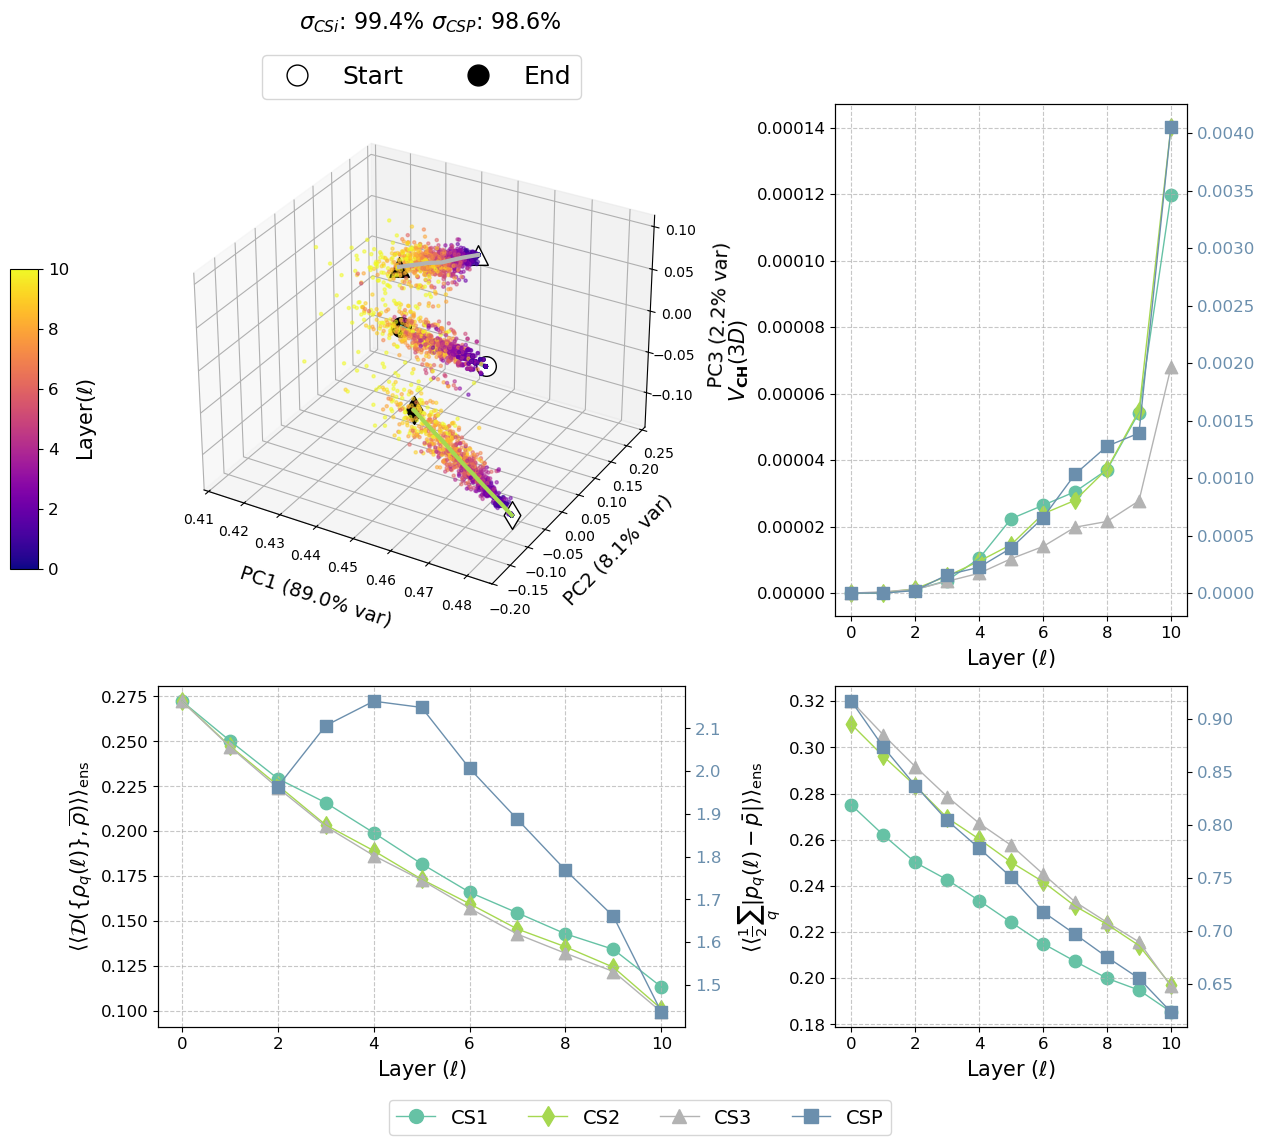

In [331]:
def analyze_R1_across_ics_four_plots_uncentered(data_dict, rule="R2", n_components=3, N=12, save_fig=True, fig_name="first_10_Steps_ics.png"):
    """
    Analyze data with four plots in a 2x2 grid:
    1. PCA plot (using uncentered PCA) for CS1/CS2/CS3 only
    2. Convex hull volume with dual y-axis (CSP on right)
    3. KL divergence (relative entropy) with dual y-axis (CSP on right)
    4. Trace distance with dual y-axis (CSP on right)
    
    With separate PCA for CS1/CS2/CS3 group and CSP
    For CSP, uses minimum number of components to reach 90% variance explained
    """    
    # Create figure with 2 rows, 2 columns with customized size ratios
    fig = plt.figure(figsize=(14, 12))
    
    # Create a GridSpec layout with different column widths
    gs = plt.GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1.5, 1])
    
    # Define markers for different ICs and map ICs to new names
    markers = ['o', 'd', '^', 's']  # circle, diamond, triangle, square
    ic_to_name = {'CS1': 'CS1', 'CS2': 'CS2', 'CS3': 'CS3', "CSP": "CSP"}
    
    # Use custom colors as specified
    ic_colors = ["#66c2a5", "#a6d850", "#b3b3b3", "#6B8FAD"]
    
    # Extract only current rule data and preprocess
    rule_data = preprocess_data({rule: data_dict[rule]})
    
    # Get time steps and trials information
    for ic, data_set in data_dict[rule].items():
        n_time_steps = len(data_set[0])
        n_trials = len(data_set)
        break
    
    # Separate data into CS1/CS2/CS3 group and CSP
    cs_group_data = []
    cs_group_labels = []
    cs_group_time_steps = []
    
    csp_data = []
    csp_labels = []
    csp_time_steps = []
    
    # Create color mapping for ICs
    ic_to_color = {}
    regular_cs = ['CS1', 'CS2', 'CS3']
    for ic in rule_data[rule].keys():
        if ic in regular_cs:
            idx = regular_cs.index(ic)
            ic_to_color[ic] = ic_colors[idx]
        elif ic == 'CSP':
            ic_to_color[ic] = ic_colors[3]  # #6B8FAD for CSP
    
    for ic, data in rule_data[rule].items():
        if ic in ['CS1', 'CS2', 'CS3']:
            cs_group_data.append(data)
            cs_group_labels.extend([ic] * len(data))
            
            # For each trial, add the time step indices
            for trial_idx in range(len(data) // n_time_steps):
                cs_group_time_steps.extend(list(range(n_time_steps)))
        elif ic == 'CSP':
            csp_data.append(data)
            csp_labels.extend([ic] * len(data))
            
            # For each trial, add the time step indices
            for trial_idx in range(len(data) // n_time_steps):
                csp_time_steps.extend(list(range(n_time_steps)))
    
    # Convert to numpy arrays
    cs_group_data = np.vstack(cs_group_data) if cs_group_data else np.array([])
    cs_group_labels = np.array(cs_group_labels)
    cs_group_time_steps = np.array(cs_group_time_steps)
    
    csp_data = np.vstack(csp_data) if csp_data else np.array([])
    csp_labels = np.array(csp_labels)
    csp_time_steps = np.array(csp_time_steps)
    
    # Fit PCA separately for the two groups
    # CS1/CS2/CS3 group - fixed n_components
    if len(cs_group_data) > 0:
        cs_projections, cs_explained_variance_ratio, cs_components = uncentered_pca(cs_group_data, n_components=n_components)
        cs_total_var_explained = np.sum(cs_explained_variance_ratio) * 100
    else:
        cs_projections, cs_explained_variance_ratio, cs_components = None, None, None
        cs_total_var_explained = 0
    
    # CSP - adaptive n_components to reach 90% variance
    csp_n_components = n_components  # Default
    if len(csp_data) > 0:
        # First try with maximum possible components to get all variance ratios
        max_possible = min(csp_data.shape[0], csp_data.shape[1])
        _, full_variance_ratio, _ = uncentered_pca(csp_data, n_components=max_possible)
        
        # Find minimum number of components needed for 90% variance
        cumulative_var = np.cumsum(full_variance_ratio)
        csp_n_components = np.argmax(cumulative_var >= 0.9) + 1  # +1 because indices start at 0
        
        # Make sure we don't exceed maximum possible or go below 3
        csp_n_components = max(3, min(csp_n_components, max_possible))
        
        # Now recompute with the optimal number of components
        csp_projections, csp_explained_variance_ratio, csp_components = uncentered_pca(csp_data, n_components=csp_n_components)
        csp_total_var_explained = np.sum(csp_explained_variance_ratio) * 100
        
        print(f"Using {csp_n_components} components for CSP PCA (explaining {csp_total_var_explained:.1f}% variance)")
    else:
        csp_projections, csp_explained_variance_ratio, csp_components = None, None, None
        csp_total_var_explained = 0
    
    # Organize projections by IC
    ic_projections = {}
    
    # For CS1/CS2/CS3 group
    for ic in ['CS1', 'CS2', 'CS3']:
        if ic in rule_data[rule] and len(cs_group_data) > 0:
            ic_mask = (cs_group_labels == ic)
            ic_projections[ic] = cs_projections[ic_mask]
    
    # For CSP
    if 'CSP' in rule_data[rule] and len(csp_data) > 0:
        ic_projections['CSP'] = csp_projections
    
    # 1. PCA Plot (3D) with larger size - ONLY for CS1, CS2, CS3
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    
    # Create a colormap for time steps
    time_cmap = plt.cm.plasma
    norm = plt.Normalize(0, n_time_steps-1)
    
    # Create an empty scatter for time colorbar
    sm = plt.cm.ScalarMappable(cmap=time_cmap, norm=norm)
    sm.set_array([])
    
    # Add text for total variance above PCA plot (for both groups)
    fig.text(0.35, 0.95, 
             r'$\sigma_{CSi}$'f': {cs_total_var_explained:.1f}% ' + 
             r'$\sigma_{CSP}$'f': {csp_total_var_explained:.1f}%', 
             ha='center', fontsize=16)
    
    # Add trajectory legend elements with markers included (only for CS1/CS2/CS3)
    legend_elements_top = []
    for i, ic in enumerate(['CS1', 'CS2', 'CS3']):
        if ic in rule_data[rule]:
            legend_name = ic_to_name.get(ic, ic)
            color = ic_to_color[ic]
            marker = markers[i % len(markers)]
            
            # Add line and marker combined for each CS
            #legend_elements_top.append(Line2D([0], [0], color=color, marker=marker, 
                                        #linestyle='-', linewidth=4, markersize=15, label=f"{legend_name}"))
    
    # Add start/end marker explanation
    legend_elements_top.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='white',
                               markeredgecolor='black', markersize=15, linestyle='none', label='Start'))
    legend_elements_top.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                               markeredgecolor='black', markersize=15, linestyle='none', label='End'))
    
    # Place the top legend
    ax1.legend(handles=legend_elements_top, loc='upper center', bbox_to_anchor=(0.5, 1.12),
              ncol=5, fontsize=18, frameon=True, framealpha=0.8)
    
    # Plot CS1/CS2/CS3 data points and trajectories
    for i, ic in enumerate(['CS1', 'CS2', 'CS3']):
        if ic in ic_projections:
            proj = ic_projections[ic]
            color = ic_to_color[ic]
            marker = markers[i % len(markers)]
            
            if proj.size > 0:
                n_trials = len(proj) // n_time_steps
                reshaped_proj = proj.reshape(n_trials, n_time_steps, -1)
                ic_times = np.tile(np.arange(n_time_steps), n_trials)
                
                # Plot individual points colored by time
                scatter = ax1.scatter(
                    proj[:, 0], proj[:, 1], proj[:, 2],
                    c=ic_times, cmap=time_cmap, norm=norm,
                    alpha=0.5, marker='.', s=20  # Small dots for time scatter
                )
                
                # Calculate mean trajectory across trials
                mean_trajectory = np.mean(reshaped_proj, axis=0)
                
                # Plot the mean trajectory line
                ax1.plot(
                    mean_trajectory[:, 0], mean_trajectory[:, 1], mean_trajectory[:, 2],
                    '-', linewidth=3, color=color, zorder=10  # Higher zorder to be on top
                )
                
                # Add markers for start and end points of mean trajectory
                # Start point: unfilled marker
                ax1.scatter(
                    mean_trajectory[0, 0], mean_trajectory[0, 1], mean_trajectory[0, 2],
                    color='white', marker=marker, s=200, edgecolors='black', linewidth=1, 
                    zorder=11  # Higher zorder to be on top
                )
                # End point: filled BLACK marker
                ax1.scatter(
                    mean_trajectory[-1, 0], mean_trajectory[-1, 1], mean_trajectory[-1, 2],
                    color='black', marker=marker, s=200, edgecolors='black', linewidth=1,
                    zorder=12  # Highest zorder to be on top of everything
                )
    
    # Create a vertical colorbar to the left of the PCA plot
    cax = plt.axes([0.05, 0.5, 0.02, 0.25])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(r'Layer$(\ell)$', size=15)
    
    # Add PCA axis labels with variance explained for CS group
    if cs_explained_variance_ratio is not None:
        ax1.set_xlabel(f'PC1 ({cs_explained_variance_ratio[0]:.1%} var)', fontsize=14, labelpad=10)
        ax1.set_ylabel(f'PC2 ({cs_explained_variance_ratio[1]:.1%} var)', fontsize=14, labelpad=10)
        ax1.set_zlabel(f'PC3 ({cs_explained_variance_ratio[2]:.1%} var)', fontsize=14, labelpad=10)
    else:
        ax1.set_xlabel('PC1', fontsize=14, labelpad=10)
        ax1.set_ylabel('PC2', fontsize=14, labelpad=10)
        ax1.set_zlabel('PC3', fontsize=14, labelpad=10)
    
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    
    # 2. Hull Volume Plot with dual y-axis
    ax2 = fig.add_subplot(gs[0, 1])
    ax2_twin = ax2.twinx()  # Create secondary y-axis for CSP
    
    hull_volumes = {}
    
    # Reorganize the data to access time steps
    ic_time_data = {}
    
    for ic in ['CS1', 'CS2', 'CS3']:
        if ic in ic_projections and ic_projections[ic].size > 0:
            ic_data = ic_projections[ic]
            
            # Verify we have enough data points
            if len(ic_data) == n_trials * n_time_steps:
                # Reshape to (n_trials, n_time_steps, n_components)
                ic_time_data[ic] = ic_data.reshape(n_trials, n_time_steps, n_components)
            else:
                print(f"Warning: IC {ic} doesn't have {n_trials * n_time_steps} data points. Cannot reshape.")
                continue
    
    # Special handling for CSP with potentially different number of components
    if 'CSP' in ic_projections and ic_projections['CSP'].size > 0:
        csp_data = ic_projections['CSP']
        
        # Verify we have enough data points
        if len(csp_data) == n_trials * n_time_steps:
            # Reshape to (n_trials, n_time_steps, csp_n_components)
            ic_time_data['CSP'] = csp_data.reshape(n_trials, n_time_steps, csp_n_components)
        else:
            print(f"Warning: CSP doesn't have {n_trials * n_time_steps} data points. Cannot reshape.")
    
    # Calculate convex hull volume at each time step for each IC
    for ic, time_data in ic_time_data.items():
        hull_volumes[ic] = []
        
        for t in range(n_time_steps):
            # Extract data points at this time step
            points_at_t = time_data[:, t, :]
            
            # Add small jitter to avoid coplanar points
            jittered_points = points_at_t + np.random.normal(0, 1e-10, points_at_t.shape)
            
            # Calculate robust volume estimate
            volume = calculate_robust_volume(jittered_points)
            hull_volumes[ic].append(volume)
    
    # Plot convex hull volumes with custom colors on appropriate axis
    for ic, volumes in hull_volumes.items():
        color = ic_to_color[ic]
        marker_idx = list(ic_to_name.keys()).index(ic)
        marker = markers[marker_idx]
        
        if ic == 'CSP':
            # Plot CSP on the right y-axis
            ax2_twin.plot(range(len(volumes)), volumes, '-', color=color, linewidth=1)
            ax2_twin.scatter(range(len(volumes)), volumes, marker=marker, 
                           s=80, color=color)
        else:
            # Plot other ICs on the left y-axis
            ax2.plot(range(len(volumes)), volumes, '-', color=color, linewidth=1)
            ax2.scatter(range(len(volumes)), volumes, marker=marker, 
                       s=80, color=color)
    
    ax2.set_xlabel(r'Layer $(\ell)$', fontsize=15)
    ax2.set_ylabel(r'$V_{\mathbf{CH}}(3 D)$', fontsize=15)
    #ax2_twin.set_ylabel(r'$V_{\mathbf{CH}}$ (CSP)', fontsize=15, color=ic_to_color['CSP'])
    ax2_twin.tick_params(axis='y', labelcolor=ic_to_color['CSP'])
    
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2_twin.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. KL Divergence Plot with dual y-axis
    ax3 = fig.add_subplot(gs[1, 0])
    ax3_twin = ax3.twinx()  # Create secondary y-axis for CSP
    
    # Thermal state reference for CS1/CS2/CS3
    reference_p = ((N-1) * 0.1 + 0.4) / N
    therm_state = np.full(N, reference_p)
    
    # Thermal state reference for CSP (uniform distribution)
    reference_p_csp = 1.0 / N
    therm_state_csp = np.full(N, reference_p_csp)
    
    # Calculate KL divergence for each IC at each time step
    kl_divergence_by_ic = {}
    
    for ic, data in data_dict[rule].items():
        kl_values = []
        data_array = np.array(data)
        
        # Choose appropriate reference state
        ref_state = therm_state_csp if ic == 'CSP' else therm_state
        
        for t in range(n_time_steps):
            # Get data for all trials at this time step
            samples_at_t = data_array[:, t, :]
            
            # Calculate KL divergence for each sample and take mean
            sample_kl = []
            for sample in samples_at_t:
                sample_kl.append(rel_diff_from_thermal(ref_state, sample, N))
            
            kl_values.append(np.mean(sample_kl))
        
        kl_divergence_by_ic[ic] = kl_values
    
    # Plot KL divergence with custom colors on appropriate axis
    for ic, kl_values in kl_divergence_by_ic.items():
        color = ic_to_color[ic]
        marker_idx = list(ic_to_name.keys()).index(ic)
        marker = markers[marker_idx]
        
        if ic == 'CSP':
            # Plot CSP on the right y-axis
            ax3_twin.plot(range(2,len(kl_values)), kl_values[2:], '-', color=color, linewidth=1)
            ax3_twin.scatter(range(2,len(kl_values)), kl_values[2:], marker=marker, 
                           s=80, color=color)
        else:
            # Plot other ICs on the left y-axis
            ax3.plot(range(len(kl_values)), kl_values, '-', color=color, linewidth=1)
            ax3.scatter(range(len(kl_values)), kl_values, marker=marker, 
                       s=80, color=color)
    
    ax3.set_xlabel(r'Layer $(\ell)$', fontsize=15)
    ax3.set_ylabel(r'$\langle\langle\mathcal{D}(\{ \rho_{q}(\ell)\},\overline{\rho})\rangle\rangle_{\rm ens}$', fontsize=15)
    #ax3_twin.set_ylabel(r'$\langle\mathcal{D}(\{ \rho_{q}(t)\},\bar{\rho})\rangle$ (CSP)', fontsize=15, color=ic_to_color['CSP'])
    ax3_twin.tick_params(axis='y', labelcolor=ic_to_color['CSP'])
    
    ax3.tick_params(axis='both', which='major', labelsize=12)
    ax3_twin.tick_params(axis='both', which='major', labelsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Trace Distance Plot with dual y-axis
    ax4 = fig.add_subplot(gs[1, 1])
    ax4_twin = ax4.twinx()  # Create secondary y-axis for CSP
    
    # Calculate trace distance for each IC at each time step
    trace_distance_by_ic = {}
    for ic, data in data_dict[rule].items():
        trace_values = []
        data_array = np.array(data)
        
        # Choose appropriate reference state
        ref_state = reference_p_csp if ic == 'CSP' else reference_p
        
        for t in range(n_time_steps):
            # Get data for all trials at this time step
            samples_at_t = data_array[:, t, :]
            
            # Calculate trace distance (sum of absolute differences)
            trace_distances = (0.5*np.abs(samples_at_t - ref_state)).sum(axis=1)
            trace_values.append(np.mean(trace_distances))
        
        trace_distance_by_ic[ic] = trace_values
    
    # Plot trace distances with custom colors on appropriate axis
    for ic, trace_values in trace_distance_by_ic.items():
        color = ic_to_color[ic]
        marker_idx = list(ic_to_name.keys()).index(ic)
        marker = markers[marker_idx]
        
        if ic == 'CSP':
            # Plot CSP on the right y-axis
            ax4_twin.plot(range(len(trace_values)), trace_values, '-', color=color, linewidth=1)
            ax4_twin.scatter(range(len(trace_values)), trace_values, marker=marker, 
                           s=80, color=color)
        else:
            # Plot other ICs on the left y-axis
            ax4.plot(range(len(trace_values)), trace_values, '-', color=color, linewidth=1)
            ax4.scatter(range(len(trace_values)), trace_values, marker=marker, 
                       s=80, color=color)
    
    ax4.set_xlabel(r'Layer $(\ell)$', fontsize=15)
    ax4.set_ylabel(r'$\langle\langle\frac{1}{2}\sum_q |p_q (\ell) - \bar{p}|\rangle\rangle_{\rm ens}$', fontsize=15)
    #ax4_twin.set_ylabel(r'$\langle\frac{1}{2}\sum_q |p_q (t) - \bar{p}|\rangle$ (CSP)', fontsize=15, color=ic_to_color['CSP'])
    ax4_twin.tick_params(axis='y', labelcolor=ic_to_color['CSP'])
    
    ax4.tick_params(axis='both', which='major', labelsize=12)
    ax4_twin.tick_params(axis='both', which='major', labelsize=12)
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    # Add a combined legend at the bottom
    legend_elements = []
    for i, ic in enumerate(rule_data[rule].keys()):
        legend_name = ic_to_name.get(ic, ic)
        color = ic_to_color[ic]
        marker_idx = list(ic_to_name.keys()).index(ic)
        marker = markers[marker_idx]
        
        # Add line and marker combined
        legend_elements.append(Line2D([0], [0], color=color, marker=marker, 
                                 linestyle='-', linewidth=1, markersize=10, label=f"{legend_name}"))
    
    # Place legend at the bottom
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02),
              ncol=len(legend_elements), fontsize=14)
    
    # Adjust layout, accounting for the vertical colorbar on the left
    plt.tight_layout(rect=[0.08, 0.06, 0.95, 0.94])  # Adjusted left and right margins
    
    if save_fig:
        plt.savefig("first_10_Steps_ics.png", dpi=300, bbox_inches='tight')
    
    # Return mock PCA objects for compatibility with existing code
    class MockPCA:
        def __init__(self, explained_variance_ratio, components):
            self.explained_variance_ratio_ = explained_variance_ratio
            self.components_ = components
    
    # Create mock PCA objects for both PCAs
    mock_pca_cs = MockPCA(cs_explained_variance_ratio, cs_components) if cs_explained_variance_ratio is not None else None
    mock_pca_csp = MockPCA(csp_explained_variance_ratio, csp_components) if csp_explained_variance_ratio is not None else None
    
    return fig, [ax1, ax2, ax3, ax4], {
        'pca_cs': mock_pca_cs,
        'pca_csp': mock_pca_csp,
        'hull_volumes': hull_volumes,
        'kl_divergence': kl_divergence_by_ic,
        'trace_distance': trace_distance_by_ic
    }
analyze_R1_across_ics_four_plots_uncentered(data_10_steps)

In [16]:
def uncentered_pca(data, n_components=3):
    """
    Perform uncentered PCA on the given data.
    
    Args:
        data: numpy array with shape (n_samples, n_features)
        n_components: number of principal components to return
        
    Returns:
        projections: data projected onto principal components
        explained_variance_ratio: proportion of variance explained by each component
        components: principal components (eigenvectors)
    """
    # Compute the uncentered second moment matrix (no centering)
    sigma = (1/data.shape[0]) * data.T @ data
    
    # Compute eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(sigma)
    
    # Sort by decreasing eigenvalue
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top components
    components = eigenvectors[:, :n_components]
    
    # Project data onto components
    projections = data @ components
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    return projections, explained_variance_ratio, components

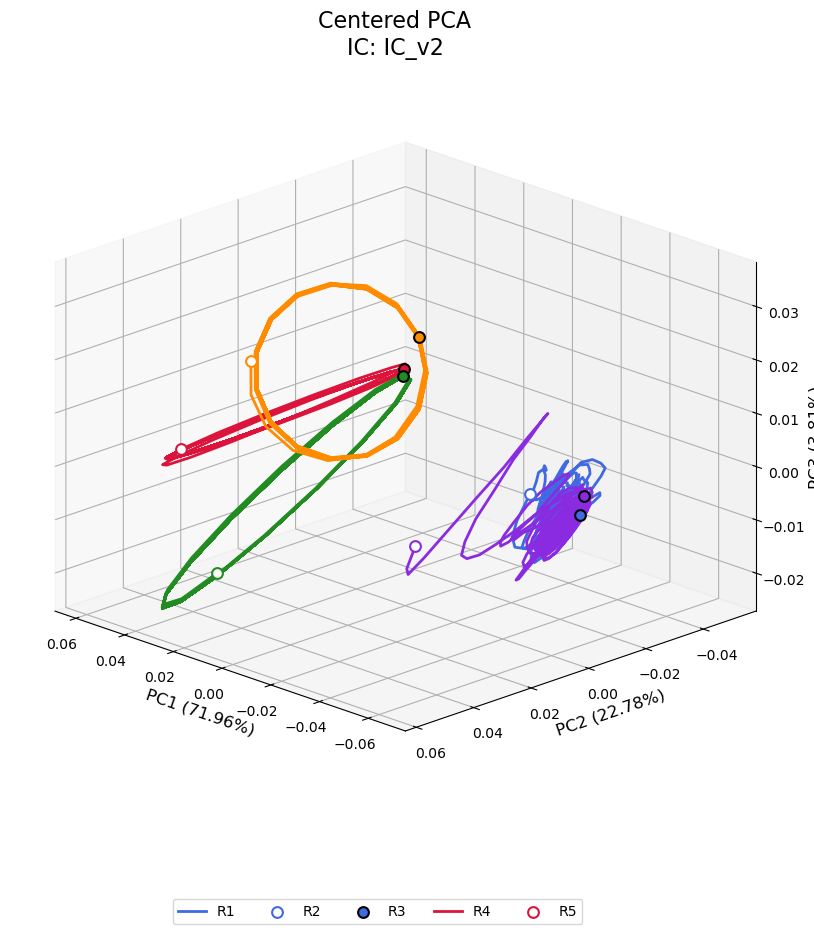

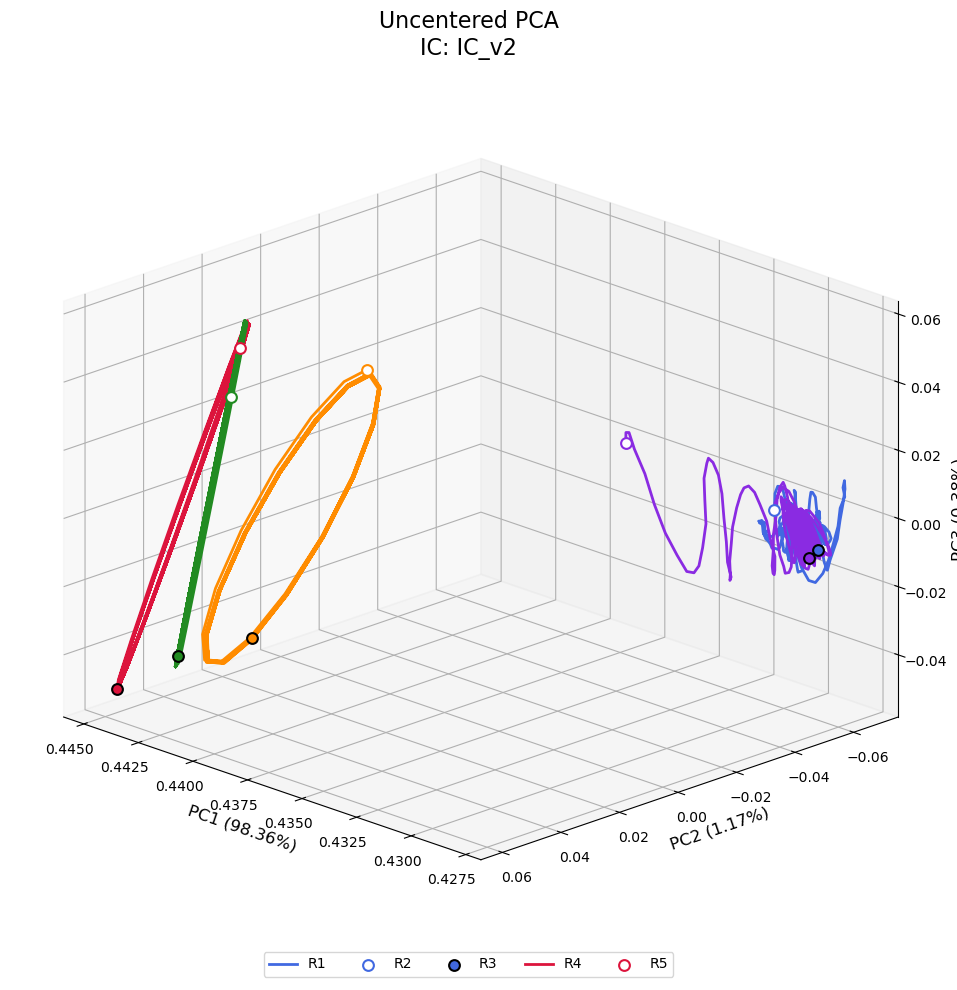

In [31]:
#Use this code when you are unsure whether yoe need to use centered or ncentered PCA
def compare_multiple_rules_uncentered_pca(data_dict, rules, ic, n_components=3, figsize=(14, 10)):
    """
    Apply uncentered PCA to multiple rules for a single initial condition and plot them together.
    
    Args:
        data_dict: Your data dictionary with structure rule -> ic -> trajectory data
        rules: List of rules to compare
        ic: The specific initial condition to analyze
        n_components: Number of principal components
        figsize: Figure size tuple
        
    Returns:
        Tuple of (centered_fig, uncentered_fig) with the plotted figures
    """    
    # Rule colors for consistent visualization
    rule_colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2', '#CD5C5C', '#20B2AA']
    rule_color_map = {rule: rule_colors[i % len(rule_colors)] for i, rule in enumerate(rules)}
    
    # Filter rules that have data for the specified IC
    available_rules = [rule for rule in rules if ic in data_dict.get(rule, {})]
    
    if not available_rules:
        print(f"No data available for IC {ic}")
        return None, None
    
    # Combine data from all rules for this IC
    all_data = np.vstack([data_dict[rule][ic] for rule in available_rules])
    
    # Split indices for each rule
    rule_indices = {}
    start_idx = 0
    for rule in available_rules:
        rule_data_size = data_dict[rule][ic].shape[0]
        end_idx = start_idx + rule_data_size
        rule_indices[rule] = (start_idx, end_idx)
        start_idx = end_idx
    
    # Create figures for centered and uncentered PCA
    centered_fig = plt.figure(figsize=figsize)
    uncentered_fig = plt.figure(figsize=figsize)
    
    ax_centered = centered_fig.add_subplot(111, projection='3d')
    ax_uncentered = uncentered_fig.add_subplot(111, projection='3d')
    
    # Perform centered PCA (sklearn's default)
    pca_centered = PCA(n_components=n_components)
    centered_projections = pca_centered.fit_transform(all_data)
    
    # Perform uncentered PCA manually
    # Compute uncentered second moment matrix
    sigma = (1/all_data.shape[0]) * all_data.T @ all_data
    
    # Compute eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(sigma)
    
    # Sort by decreasing eigenvalue
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top components
    components = eigenvectors[:, :n_components]
    
    # Project data onto components
    uncentered_projections = all_data @ components
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    # Plot each rule's trajectory
    for rule in available_rules:
        start, end = rule_indices[rule]
        color = rule_color_map[rule]
        
        # Plot centered PCA
        ax_centered.plot(
            centered_projections[start:end, 0], 
            centered_projections[start:end, 1], 
            centered_projections[start:end, 2], 
            '-', linewidth=1, color=color, label=rule
        )
        
        # Add markers for start and end points
        ax_centered.scatter(
            centered_projections[start, 0], centered_projections[start, 1], centered_projections[start, 2],
            color='white', marker='o', s=60, edgecolors=color, linewidth=1.5
        )
        ax_centered.scatter(
            centered_projections[end-1, 0], centered_projections[end-1, 1], centered_projections[end-1, 2],
            color=color, marker='o', s=60, edgecolors='black', linewidth=1.5
        )
        
        # Plot uncentered PCA
        ax_uncentered.plot(
            uncentered_projections[start:end, 0], 
            uncentered_projections[start:end, 1], 
            uncentered_projections[start:end, 2], 
            '-', linewidth=1, color=color, label=rule
        )
        
        # Add markers for start and end points
        ax_uncentered.scatter(
            uncentered_projections[start, 0], uncentered_projections[start, 1], uncentered_projections[start, 2],
            color='white', marker='o', s=60, edgecolors=color, linewidth=1.5
        )
        ax_uncentered.scatter(
            uncentered_projections[end-1, 0], uncentered_projections[end-1, 1], uncentered_projections[end-1, 2],
            color=color, marker='o', s=60, edgecolors='black', linewidth=1.5
        )
    
    # Set labels and titles
    ax_centered.set_xlabel(f'PC1 ({pca_centered.explained_variance_ratio_[0]:.2%})', fontsize=12)
    ax_centered.set_ylabel(f'PC2 ({pca_centered.explained_variance_ratio_[1]:.2%})', fontsize=12)
    ax_centered.set_zlabel(f'PC3 ({pca_centered.explained_variance_ratio_[2]:.2%})', fontsize=12)
    ax_centered.set_title(f'Centered PCA\nIC: {ic}', fontsize=16)
    
    ax_uncentered.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.2%})', fontsize=12)
    ax_uncentered.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.2%})', fontsize=12)
    ax_uncentered.set_zlabel(f'PC3 ({explained_variance_ratio[2]:.2%})', fontsize=12)
    ax_uncentered.set_title(f'Uncentered PCA\nIC: {ic}', fontsize=16)
    
    # Adjust view
    ax_centered.view_init(elev=20, azim=135)
    ax_uncentered.view_init(elev=20, azim=135)
    ax_centered.set_proj_type('ortho')
    ax_uncentered.set_proj_type('ortho')
    
    # Add legends
    centered_fig.legend(available_rules, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(available_rules))
    uncentered_fig.legend(available_rules, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(available_rules))
    
    plt.tight_layout()
    
    # Save figures
    centered_fig.savefig(f'centered_pca_comparison_{ic}.png', dpi=300, bbox_inches='tight')
    uncentered_fig.savefig(f'uncentered_pca_comparison_{ic}.png', dpi=300, bbox_inches='tight')
    
    return centered_fig, uncentered_fig

# Example usage:
centered_fig, uncentered_fig = compare_multiple_rules_uncentered_pca(
    data_ens_avg, ['R1', 'R2', 'R3','R4','R5'], 'CS3', n_components=3, figsize=(14, 10)
 )

TypeError: list indices must be integers or slices, not str

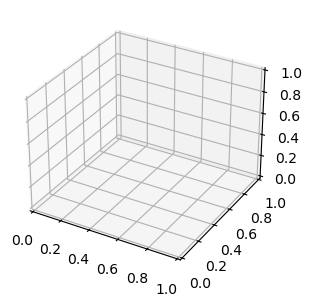

In [91]:
def plot_uncentered_pca_comparison(data_dict, rules, ics, n_components=3, structure='time_first', 
                                  reference_thermal_state=None, figsize=(20, 24)):
    """
    Create comprehensive visualization with uncentered PCA:
    - First figure: Uncentered PCA across ICs for each rule (one plot per rule)
    - Second figure: Uncentered PCA across rules for each IC (one plot per IC)
    - Third and fourth figures: KL Divergence and Trace Distance metrics
    
    Args:
        data_dict: Dictionary with structure rule -> ic -> single trajectory
        rules: List of rules to compare
        ics: List of IC indices to analyze
        n_components: Number of PCA components
        structure: Data structure format ('time_first', 'trial_first', or 'qubit_first')
        reference_thermal_state: Reference thermal state to compute divergences against
        figsize: Figure size tuple (width, height)
    """
    # Map IC names to more descriptive labels
    ic_name_map = {ics[0]: "CS1", ics[1]: "CS2", ics[2]: "CS3"} if len(ics) >= 3 else {ic: f"CS{i+1}" for i, ic in enumerate(ics)}
    
    # Specific colors for ICs and rules
    ic_colors = cm.Set2(np.linspace(0, 1, max(3, len(ics))))
    rule_colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    
    # Map colors to rules and ICs
    rule_color_map = {rule: rule_colors[i % len(rule_colors)] for i, rule in enumerate(rules)}
    ic_color_map = {ic: ic_colors[i % len(ic_colors)] for i, ic in enumerate(ics)}
    
    # Define marker shapes for ICs
    ic_marker_map = {ics[0]: 'o', ics[1]: 'D', ics[2]: '^'} if len(ics) >= 3 else {ic: ['o', 'D', '^', 's', 'p'][i % 5] for i, ic in enumerate(ics)}
    
    # Preprocess data to ensure consistent format
    processed_dict = {}
    n_time_steps = None
    n_qubits = None
    
    for rule in rules:
        processed_dict[rule] = {}
        for ic in ics:
            if ic in data_dict.get(rule, {}):
                # Get the data (ensemble-averaged trajectory)
                data = np.array(data_dict[rule][ic])
                
                # Determine time steps and qubits if not already set
                if n_time_steps is None or n_qubits is None:
                    if structure == 'time_first':  # (time_steps, n_qubits)
                        n_time_steps = data.shape[0]
                        n_qubits = data.shape[1]
                    elif structure == 'qubit_first':  # (n_qubits, time_steps)
                        n_qubits = data.shape[0]
                        n_time_steps = data.shape[1]
                    else:  # trial_first
                        n_time_steps = data.shape[1]
                        n_qubits = data.shape[2]  
                
                # Process according to structure
                if structure == 'qubit_first':  # (n_qubits, time_steps)
                    processed_dict[rule][ic] = data.T
                elif structure == 'time_first':  # Already (time_steps, features)
                    processed_dict[rule][ic] = data
                else:  # trial_first, squeeze out singleton dimension
                    processed_dict[rule][ic] = np.squeeze(data)
    
    # Function to compute uncentered PCA
    def uncentered_pca(data, n_components=3):
        # Compute uncentered second moment matrix
        sigma = (1/data.shape[0]) * data.T @ data
        
        # Compute eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        
        # Sort by decreasing eigenvalue
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top components
        components = eigenvectors[:, :n_components]
        
        # Project data onto components
        projections = data @ components
        
        # Calculate explained variance ratio
        explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
        
        return projections, components, explained_variance_ratio
    ic_colors = ["#66c2a5","#a6d850","#b3b3b3","#6B8FAD"]
    # ---- FIRST FIGURE: Uncentered PCA across ICs for each rule ----
    fig_pca_by_rule = plt.figure(figsize=(20, 5 * (len(rules) // 3 + 1)))
    gs_pca_by_rule = gridspec.GridSpec(len(rules) // 3 + 1, 5)
    gs_pca_by_rule.update(wspace=0.2, hspace=0.2)
    
    # Create custom legend elements for this figure
    legend_elements_by_rule = []
    
    for r_idx, rule in enumerate(rules):
        row, col = r_idx // 3, r_idx % 3
        ax = fig_pca_by_rule.add_subplot(gs_pca_by_rule[row, col], projection='3d')
        ax.dist = 11
        
        # Get all ICs for this rule
        available_ics = [ic for ic in ics if ic in processed_dict[rule]]
        
        if not available_ics:
            ax.text(0.5, 0.5, f"No data for rule {rule}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"Rule: {rule}")
            continue
        
        # Combine data from all ICs for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for ic in available_ics])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by IC
        ic_projections = {}
        start_idx = 0
        for ic in available_ics:
            ic_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + ic_data_size
            ic_projections[ic] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each IC trajectory
        for ic in available_ics:
            proj = ic_projections[ic]
            color = ic_colors[ic]
            marker = ic_marker_map[ic]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1, color=color, label=f'{ic_name_map[ic]}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors=color, linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color=color, marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once)
            if r_idx == 0:
                legend_elements_by_rule.append(Line2D([0], [0], color=color, marker=marker, 
                                             linestyle='-', linewidth=1, markersize=8,
                                             label=f'{ic_name_map[ic]}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f'({explained_variance_ratio[0]:.2%})',fontsize=12)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=12)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=12)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{rule}',fontsize=16)
        ax.view_init(elev=20, azim=135)
        ax.set_proj_type('ortho')
    
    # Add a single legend for all subplots
    fig_pca_by_rule.legend(handles=legend_elements_by_rule, loc='lower center', 
                         bbox_to_anchor=(0.55, 0.3), ncol=len(ics), fontsize=14)
    
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.35, hspace=0.3)
    plt.savefig('uncentered_pca_all_ics_per_rule.png', dpi=300, bbox_inches='tight')
    
    # ---- SECOND FIGURE: Uncentered PCA across rules for each IC ----
    fig_pca_by_ic = plt.figure(figsize=(20, 6 * (len(ics) // 3 + 1)))
    gs_pca_by_ic = gridspec.GridSpec(len(ics) // 3 + 1, 3)
    gs_pca_by_ic.update(wspace=0.3, hspace=0.4)
    
    # Create custom legend elements for this figure
    legend_elements_by_ic = []
    
    for ic_idx, ic in enumerate(ics):
        marker = ic_marker_map[ic]
        row, col = ic_idx // 3, ic_idx % 3
        ax = fig_pca_by_ic.add_subplot(gs_pca_by_ic[row, col], projection='3d')
        ax.dist = 11
        
        # Get all rules that have this IC
        available_rules = [rule for rule in rules if ic in processed_dict.get(rule, {})]
        
        if not available_rules:
            ax.text(0.5, 0.5, f"No data for IC {ic_name_map[ic]}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"IC: {ic_name_map[ic]}")
            continue
        
        # Combine data from all rules for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for rule in available_rules])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by rule
        rule_projections = {}
        start_idx = 0
        for rule in available_rules:
            rule_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + rule_data_size
            rule_projections[rule] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each rule trajectory
        for rule in available_rules:
            proj = rule_projections[rule]
            color = rule_color_map[rule]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1, color=color, label=f'Rule {rule}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors=color, linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color=color, marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once per rule)
            if ic_idx == 0 and rule not in [elem.get_label().split()[-1] for elem in legend_elements_by_ic]:
                legend_elements_by_ic.append(Line2D([0], [0], color=color, marker='o', 
                                             linestyle='-', linewidth=1, markersize=8,
                                             label=f'{rule}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f' ({explained_variance_ratio[0]:.2%})',fontsize=16)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=16)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=16)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{ic_name_map[ic]}',fontsize=20)
        ax.view_init(elev=20, azim=135)
        ax.set_proj_type('ortho')
    
    # Add a single legend for all subplots
    fig_pca_by_ic.legend(handles=legend_elements_by_ic, loc='lower center', 
                        bbox_to_anchor=(0.5, 0.5), ncol=len(rules), fontsize=18)
    
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.35, hspace=0.3)
    plt.savefig('uncentered_pca_all_rules_per_ic.png', dpi=300, bbox_inches='tight')
    
    # If reference state is provided, compute divergence metrics
    if reference_thermal_state is not None:
        # Helper function to compute KL divergence
        def rel_diff_from_thermal(therm_state, state, N):
            # Compute the uniform reference probability
            pop_ref = np.sum(therm_state) / N
            
            # Calculate KL divergence terms
            kl_terms = []
            for p in state:
                # KL for binary distribution: p log(p/q) + (1-p)log((1-p)/(1-q))
                term = 0
                if 0 < p < 1 and 0 < pop_ref < 1:
                    term += p * np.log(p / pop_ref) 
                    term += (1 - p) * np.log((1 - p) / (1 - pop_ref))
                kl_terms.append(term)
            
            return np.sum(kl_terms)
        
        # Compute KL divergence and trace distance for all rules and ICs
        kl_divergence_data = {}
        trace_distance_data = {}
        
        for rule in rules:
            kl_divergence_data[rule] = {}
            trace_distance_data[rule] = {}
            
            for ic in ics:
                if ic in processed_dict.get(rule, {}):
                    data = processed_dict[rule][ic]
                    n_time_steps = data.shape[0]
                    
                    # Calculate KL divergence and trace distance for each time step
                    kl_values = []
                    trace_dist_values = []
                    
                    for t in range(n_time_steps):
                        # Get state at time t
                        state_at_t = data[t]
                        
                        # Calculate KL divergence
                        kl_value = rel_diff_from_thermal(reference_thermal_state, state_at_t, len(state_at_t))
                        kl_values.append(kl_value)
                        
                        # Calculate trace distance: 0.5 * sum(|p - q|)
                        trace_dist = 0.5 * np.sum(np.abs(state_at_t - reference_thermal_state))
                        trace_dist_values.append(trace_dist)
                    
                    # Store computed values
                    kl_divergence_data[rule][ic] = kl_values
                    trace_distance_data[rule][ic] = trace_dist_values
        
        # ---- THIRD FIGURE: KL Divergence and Trace Distance per Rule ----
        fig_div_by_rule = plt.figure(figsize=(20, 6 * len(rules)))
        gs_div_by_rule = gridspec.GridSpec(len(rules), 2, height_ratios=[1] * len(rules))
        gs_div_by_rule.update(wspace=0.3, hspace=0.4)
        
        legend_elements_div_by_rule = []
        
        for r_idx, rule in enumerate(rules):
            # KL Divergence subplot
            ax_kl = fig_div_by_rule.add_subplot(gs_div_by_rule[r_idx, 0])
            ax_kl.set_xlabel('l',fontsize=16)
            ax_kl.set_ylabel('Average Relative Entropy',fontsize=16)
            ax_kl.grid(True, linestyle='--', alpha=0.7)
            
            # Trace Distance subplot
            ax_td = fig_div_by_rule.add_subplot(gs_div_by_rule[r_idx, 1])
            ax_td.set_xlabel('l',fontsize=16)
            ax_td.set_ylabel('Average Trace Distance',fontsize=16)
            ax_td.grid(True, linestyle='--', alpha=0.7)
            
            for ic in ics:
                if ic in kl_divergence_data.get(rule, {}):
                    # Get the data
                    kl_values = kl_divergence_data[rule][ic]
                    td_values = trace_distance_data[rule][ic]
                    time_steps = np.arange(len(kl_values))
                    
                    color = ic_color_map[ic]
                    marker = ic_marker_map[ic]
                    
                    # Plot raw values with low alpha
                    ax_kl.plot(time_steps, kl_values, '-', marker=marker, markevery=max(1, len(time_steps)//20),
                              linewidth=1, markersize=4, alpha=0.3, 
                              color=color, label=f'{ic_name_map[ic]}')
                    
                    ax_td.plot(time_steps, td_values, '-', marker=marker, markevery=max(1, len(time_steps)//20),
                              linewidth=1, markersize=4, alpha=0.3, 
                              color=color, label=f'{ic_name_map[ic]}')
                    
                    # Calculate and plot smoothed values
                    window_size = min(20, len(time_steps)//4) if len(time_steps) > 40 else 5
                    if len(time_steps) >= window_size:
                        # Smooth KL divergence
                        kl_avg = np.convolve(kl_values, np.ones(window_size)/window_size, mode='valid')
                        pad_size = len(kl_values) - len(kl_avg)
                        kl_avg = np.pad(kl_avg, (pad_size//2, pad_size - pad_size//2), 'edge')
                        ax_kl.plot(time_steps, kl_avg, '-', 
                                  linewidth=1.5, alpha=0.9, color=color)
                        
                        # Smooth trace distance
                        td_avg = np.convolve(td_values, np.ones(window_size)/window_size, mode='valid')
                        pad_size = len(td_values) - len(td_avg)
                        td_avg = np.pad(td_avg, (pad_size//2, pad_size - pad_size//2), 'edge')
                        ax_td.plot(time_steps, td_avg, '-', 
                                  linewidth=1.5, alpha=0.9, color=color)
                    
                    # Add to legend elements (only once)
                    if r_idx == 0:
                        legend_elements_div_by_rule.append(Line2D([0], [0], color=color, marker=marker, 
                                                     linestyle='-', linewidth=1, markersize=8,
                                                     label=f'{ic_name_map[ic]}'))
        
        # Add a single legend for all subplots
        fig_div_by_rule.legend(handles=legend_elements_div_by_rule, loc='lower center', 
                             bbox_to_anchor=(0.5, 0.02), ncol=len(ics), fontsize=12)
        
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.35, hspace=0.3)
        plt.savefig('uncentered_rel_ent_per_rule.png', dpi=300, bbox_inches='tight')
        
        # ---- FOURTH FIGURE: KL Divergence and Trace Distance per IC ----
        fig_div_by_ic = plt.figure(figsize=(20, 6 * len(ics)))
        gs_div_by_ic = gridspec.GridSpec(len(ics), 2, height_ratios=[1] * len(ics))
        gs_div_by_ic.update(wspace=0.3, hspace=0.4)
        
        legend_elements_div_by_ic = []
        
        for ic_idx, ic in enumerate(ics):
            # KL Divergence subplot
            ax_kl = fig_div_by_ic.add_subplot(gs_div_by_ic[ic_idx, 0])
            ax_kl.set_xlabel('l',fontsize=16)
            ax_kl.set_ylabel('Average Relative Entropy',fontsize=16)
            ax_kl.grid(True, linestyle='--', alpha=0.7)
            
            # Trace Distance subplot
            ax_td = fig_div_by_ic.add_subplot(gs_div_by_ic[ic_idx, 1])
            ax_td.set_xlabel('l',fontsize=16)
            ax_td.set_ylabel('Average Trace Distance',fontsize=16)
            ax_td.grid(True, linestyle='--', alpha=0.7)
            
            max_time_steps = 0
            
            for rule in rules:
                if ic in kl_divergence_data.get(rule, {}):
                    # Get the data
                    kl_values = kl_divergence_data[rule][ic]
                    td_values = trace_distance_data[rule][ic]
                    time_steps = np.arange(len(kl_values))
                    max_time_steps = max(max_time_steps, len(time_steps))
                    
                    color = rule_color_map[rule]
                    
                    # Plot raw values with low alpha
                    ax_kl.plot(time_steps, kl_values, '-o', markevery=max(1, len(time_steps)//20),
                              linewidth=1, markersize=4, alpha=0.3, 
                              color=color, label=f'Rule {rule}')
                    
                    ax_td.plot(time_steps, td_values, '-o', markevery=max(1, len(time_steps)//20), 
                              linewidth=1, markersize=4, alpha=0.3, 
                              color=color, label=f'Rule {rule}')
                    
                    # Calculate and plot smoothed values
                    window_size = min(20, len(time_steps)//4) if len(time_steps) > 40 else 5
                    if len(time_steps) >= window_size:
                        # Smooth KL divergence
                        kl_avg = np.convolve(kl_values, np.ones(window_size)/window_size, mode='valid')
                        pad_size = len(kl_values) - len(kl_avg)
                        kl_avg = np.pad(kl_avg, (pad_size//2, pad_size - pad_size//2), 'edge')
                        ax_kl.plot(time_steps, kl_avg, '-', 
                                  linewidth=1.5, alpha=0.9, color=color)
                        
                        # Smooth trace distance
                        td_avg = np.convolve(td_values, np.ones(window_size)/window_size, mode='valid')
                        pad_size = len(td_values) - len(td_avg)
                        td_avg = np.pad(td_avg, (pad_size//2, pad_size - pad_size//2), 'edge')
                        ax_td.plot(time_steps, td_avg, '-', 
                                  linewidth=1.5, alpha=0.9, color=color)
                    
                    # Add to legend elements (only once)
                    if ic_idx == 0:
                        legend_elements_div_by_ic.append(Line2D([0], [0], color=color, marker='o', 
                                                     linestyle='-', linewidth=1, markersize=8,
                                                     label=f'{rule}'))
            
            # Set axis limits for better comparison
            if max_time_steps > 0:
                ax_kl.set_xlim([0, max_time_steps])
                ax_td.set_xlim([0, max_time_steps])
        
        # Add a single legend for all subplots
        fig_div_by_ic.legend(handles=legend_elements_div_by_ic, loc='lower center', 
                            bbox_to_anchor=(0.5, 0.05), ncol=len(rules), fontsize=16)
        
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.35, hspace=0.3)
        plt.savefig('uncentered_rel_ent_per_ic.png', dpi=300, bbox_inches='tight')
        
        return fig_pca_by_rule, fig_pca_by_ic, fig_div_by_rule, fig_div_by_ic
    
    return fig_pca_by_rule, fig_pca_by_ic


N=12
reference_p = ((N-1) * 0.1 + 0.4) / N
fig, fig_entropy = plot_uncentered_pca_comparison(
     data_ens_avg, 
     rules=['R1', 'R2', 'R3','R4','R5'], 
     ics=['CS1', 'CS2', 'CS3','CSP'], 
     reference_thermal_state=reference_p )

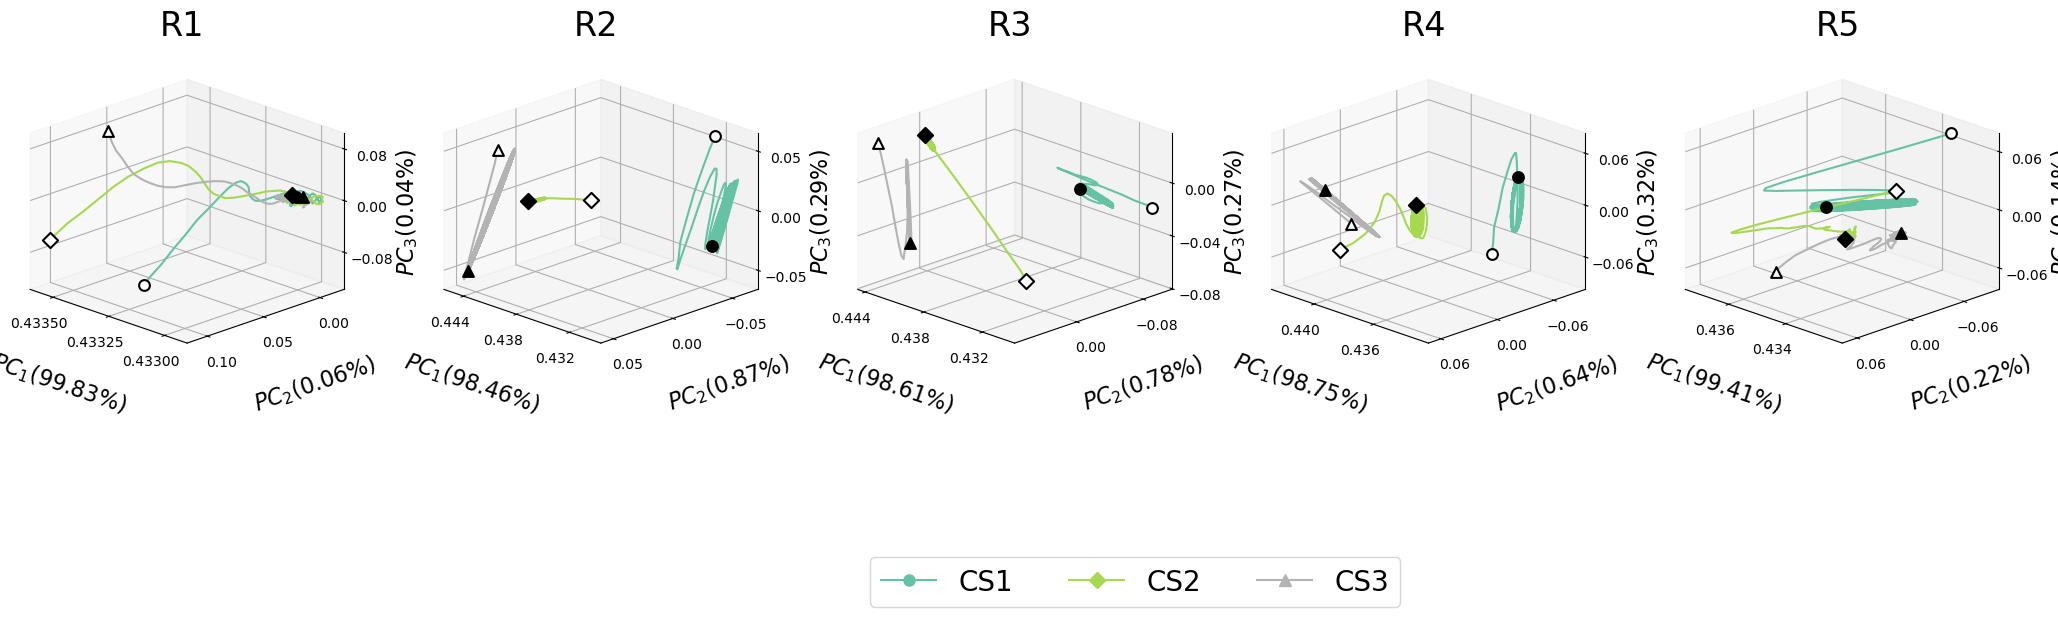

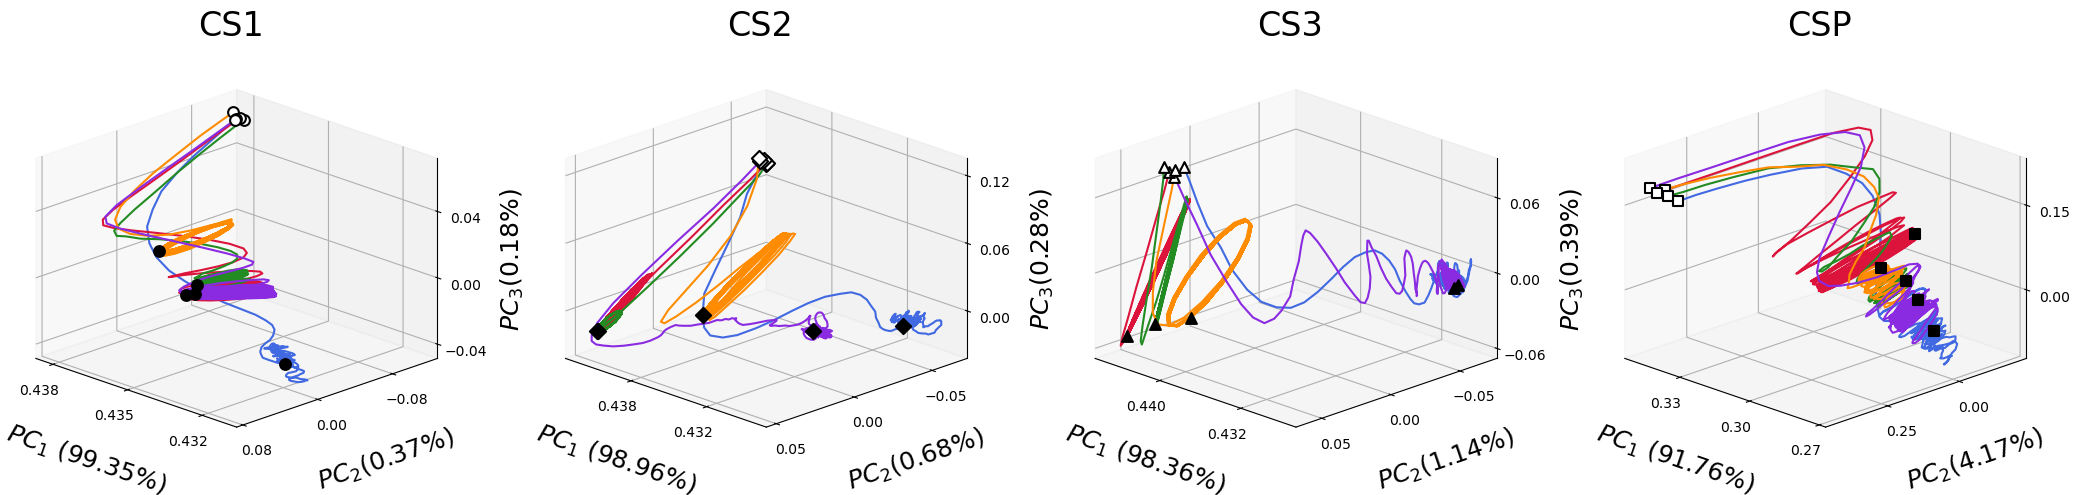

In [437]:


def plot_uncentered_pca_comparison(data_dict, rules, ics, n_components=3, structure='time_first'):
    """
    Create comprehensive visualization with uncentered PCA:
    - First figure: Uncentered PCA across ICs for each rule (all rules in one row)
    - Second figure: Uncentered PCA across rules for each IC (all ICs in one row)
    
    Args:
        data_dict: Dictionary with structure rule -> ic -> single trajectory
        rules: List of rules to compare
        ics: List of IC indices to analyze
        n_components: Number of PCA components
        structure: Data structure format ('time_first', 'trial_first', or 'qubit_first')
    """
    # Filter ICs for PCA per rule (only use CS1, CS2, CS3)
    ics_for_per_rule = [ic for ic in ics if ic in ['CS1', 'CS2', 'CS3']]
    
    # Map IC names to more descriptive labels
    ic_name_map = {'CS1': "CS1", 'CS2': "CS2", 'CS3': "CS3", 'CSP': "CSP"}
    
    # Specific colors for ICs and rules
    ic_colors = ["#66c2a5","#a6d850","#b3b3b3","#6B8FAD"]
    rule_colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    
    # Map colors to rules and ICs
    rule_color_map = {rule: rule_colors[i % len(rule_colors)] for i, rule in enumerate(rules)}
    ic_color_map = {ic: ic_colors[i % len(ic_colors)] for i, ic in enumerate(ics)}
    
    # Define marker shapes for ICs
    ic_marker_map = {'CS1': 'o', 'CS2': 'D', 'CS3': '^', 'CSP': 's'}
    
    # Preprocess data to ensure consistent format
    processed_dict = {}
    n_time_steps = None
    n_qubits = None
    
    for rule in rules:
        processed_dict[rule] = {}
        for ic in ics:
            if ic in data_dict.get(rule, {}):
                # Get the data (ensemble-averaged trajectory)
                data = np.array(data_dict[rule][ic])
                
                # Determine time steps and qubits if not already set
                if n_time_steps is None or n_qubits is None:
                    if structure == 'time_first':  # (time_steps, n_qubits)
                        n_time_steps = data.shape[0]
                        n_qubits = data.shape[1]
                    elif structure == 'qubit_first':  # (n_qubits, time_steps)
                        n_qubits = data.shape[0]
                        n_time_steps = data.shape[1]
                    else:  # trial_first
                        n_time_steps = data.shape[1]
                        n_qubits = data.shape[2]  
                
                # Process according to structure
                if structure == 'qubit_first':  # (n_qubits, time_steps)
                    processed_dict[rule][ic] = data.T
                elif structure == 'time_first':  # Already (time_steps, features)
                    processed_dict[rule][ic] = data
                else:  # trial_first, squeeze out singleton dimension
                    processed_dict[rule][ic] = np.squeeze(data)
    
    # Function to compute uncentered PCA
    def uncentered_pca(data, n_components=3):
        # Compute uncentered second moment matrix
        sigma = (1/data.shape[0]) * data.T @ data
        
        # Compute eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        
        # Sort by decreasing eigenvalue
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top components
        components = eigenvectors[:, :n_components]
        
        # Project data onto components
        projections = data @ components
        
        # Calculate explained variance ratio
        explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
        
        return projections, components, explained_variance_ratio
    
    # ---- FIRST FIGURE: Uncentered PCA across ICs for each rule (all in one row) ----
    fig_pca_by_rule = plt.figure(figsize=(25, 6))
    gs_pca_by_rule = gridspec.GridSpec(1, len(rules))
    gs_pca_by_rule.update(wspace=0.2, hspace=0.4)
    
    # Create custom legend elements for this figure
    legend_elements_by_rule = []
    
    for r_idx, rule in enumerate(rules):
        ax = fig_pca_by_rule.add_subplot(gs_pca_by_rule[0, r_idx], projection='3d')
        ax.dist = 11
        
        # Get all ICs for this rule (only the specified ones for per-rule plot)
        available_ics = [ic for ic in ics_for_per_rule if ic in processed_dict[rule]]
        
        if not available_ics:
            # For 3D axes, we need to provide x, y, z coordinates for the text
            ax.text(0, 0, 0, f"No data for rule {rule}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"Rule: {rule}")
            continue
        
        # Combine data from all ICs for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for ic in available_ics])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by IC
        ic_projections = {}
        start_idx = 0
        for ic in available_ics:
            ic_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + ic_data_size
            ic_projections[ic] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each IC trajectory
        for ic in available_ics:
            proj = ic_projections[ic]
            color = ic_color_map[ic]
            marker = ic_marker_map[ic]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1.5, color=color, label=f'{ic_name_map[ic]}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color='black', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once)
            if r_idx == 0:
                legend_elements_by_rule.append(Line2D([0], [0], color=color, marker=marker, 
                                             linestyle='-', linewidth=1.5, markersize=8,
                                             label=f'{ic_name_map[ic]}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f'({explained_variance_ratio[0]:.2%})',fontsize=16)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=16)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=16)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{rule}',fontsize=24)
        ax.view_init(elev=20, azim=135)
        ax.set_proj_type('ortho')

        ax.xaxis.labelpad = 20
        ax.yaxis.labelpad = 20
        ax.zaxis.labelpad = 5
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    # Add a single legend for all subplots
    fig_pca_by_rule.legend(handles=legend_elements_by_rule, loc='lower center', 
                         bbox_to_anchor=(0.5, -0.15), ncol=len(ics_for_per_rule), fontsize=20)
    
    plt.subplots_adjust(bottom=0.15, right=0.85, left=0.05, top=0.9, wspace=0.3)
    plt.savefig('uncentered_pca_all_ics_per_rule.png', dpi=300, bbox_inches='tight',pad_inches=1)
    
    # ---- SECOND FIGURE: Uncentered PCA across rules for each IC (all in one row) ----
    # Use the specific ICs: CS1, CS2, CS3, CSP
    specific_ics = ['CS1', 'CS2', 'CS3', 'CSP']
    available_specific_ics = [ic for ic in specific_ics if ic in ics]
    
    fig_pca_by_ic = plt.figure(figsize=(32, 6))
    gs_pca_by_ic = gridspec.GridSpec(1, len(available_specific_ics)+1)
    gs_pca_by_ic.update(wspace=0.2, hspace=0.1) 
    
    # Create custom legend elements for this figure
    legend_elements_by_ic = []
    
    for ic_idx, ic in enumerate(available_specific_ics):
        marker = ic_marker_map[ic]
        ax = fig_pca_by_ic.add_subplot(gs_pca_by_ic[0, ic_idx], projection='3d')
        ax.dist = 11
        
        # Get all rules that have this IC
        available_rules = [rule for rule in rules if ic in processed_dict.get(rule, {})]
        
        if not available_rules:
            # Fixed: Add z-coordinate for 3D text
            ax.text(0, 0, 0, f"No data for IC {ic_name_map[ic]}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"IC: {ic_name_map[ic]}")
            continue
        
        # Combine data from all rules for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for rule in available_rules])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by rule
        rule_projections = {}
        start_idx = 0
        for rule in available_rules:
            rule_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + rule_data_size
            rule_projections[rule] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each rule trajectory
        for rule in available_rules:
            proj = rule_projections[rule]
            color = rule_color_map[rule]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], '-', 
                   linewidth=1.5, color=color, label=f'Rule {rule}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], proj[0, 2], 
                      color='white', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], proj[-1, 2], 
                      color='black', marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once per rule)
            if ic_idx == 0 and rule not in [elem.get_label().split()[-1] for elem in legend_elements_by_ic]:
                legend_elements_by_ic.append(Line2D([0], [0], color=color, marker='o', 
                                             linestyle='-', linewidth=1.5, markersize=8,
                                             label=f'{rule}'))
        ax.xaxis.labelpad = 20
        ax.yaxis.labelpad = 20
        ax.zaxis.labelpad = 10

        
        ax.set_xlabel(r'$PC_1$'f' ({explained_variance_ratio[0]:.2%})',fontsize=18)
        ax.set_ylabel(r'$PC_2$'f'({explained_variance_ratio[1]:.2%})',fontsize=18)
        ax.set_zlabel(r'$PC_3$'f'({explained_variance_ratio[2]:.2%})',fontsize=18)
        ax.zaxis.set_rotate_label(False)
        ax.zaxis.label.set_rotation(90)
        ax.zaxis.label.set_horizontalalignment('center')
        ax.set_title(f'{ic_name_map[ic]}',fontsize=24)
        ax.view_init(elev=20, azim=135)
        ax.set_proj_type('ortho')
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    # Add a single legend for all subplots
    #fig_pca_by_ic.legend(handles=legend_elements_by_ic, loc='lower center', 
    #                    bbox_to_anchor=(0.35, -0.15), ncol=len(rules), fontsize=20)
    
    plt.subplots_adjust(bottom=0.15, right=0.85, left=0.05, top=0.9, wspace=0.3)
    plt.savefig('uncentered_pca_all_rules_per_ic.png', dpi=300, bbox_inches='tight',pad_inches=1)
    
    return fig_pca_by_rule, fig_pca_by_ic
N=12
reference_p = ((N-1) * 0.1 + 0.4) / N
fig, fig_entropy = plot_uncentered_pca_comparison(
     data_ens_avg, 
     rules=['R1', 'R2', 'R3','R4','R5'], 
     ics=['CS1', 'CS2', 'CS3','CSP'])

/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_30513/2930749294.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/58/gxcqk5bd4055b6n0b6yszvlw0000gn/T/ipykernel_30513/2930749294.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


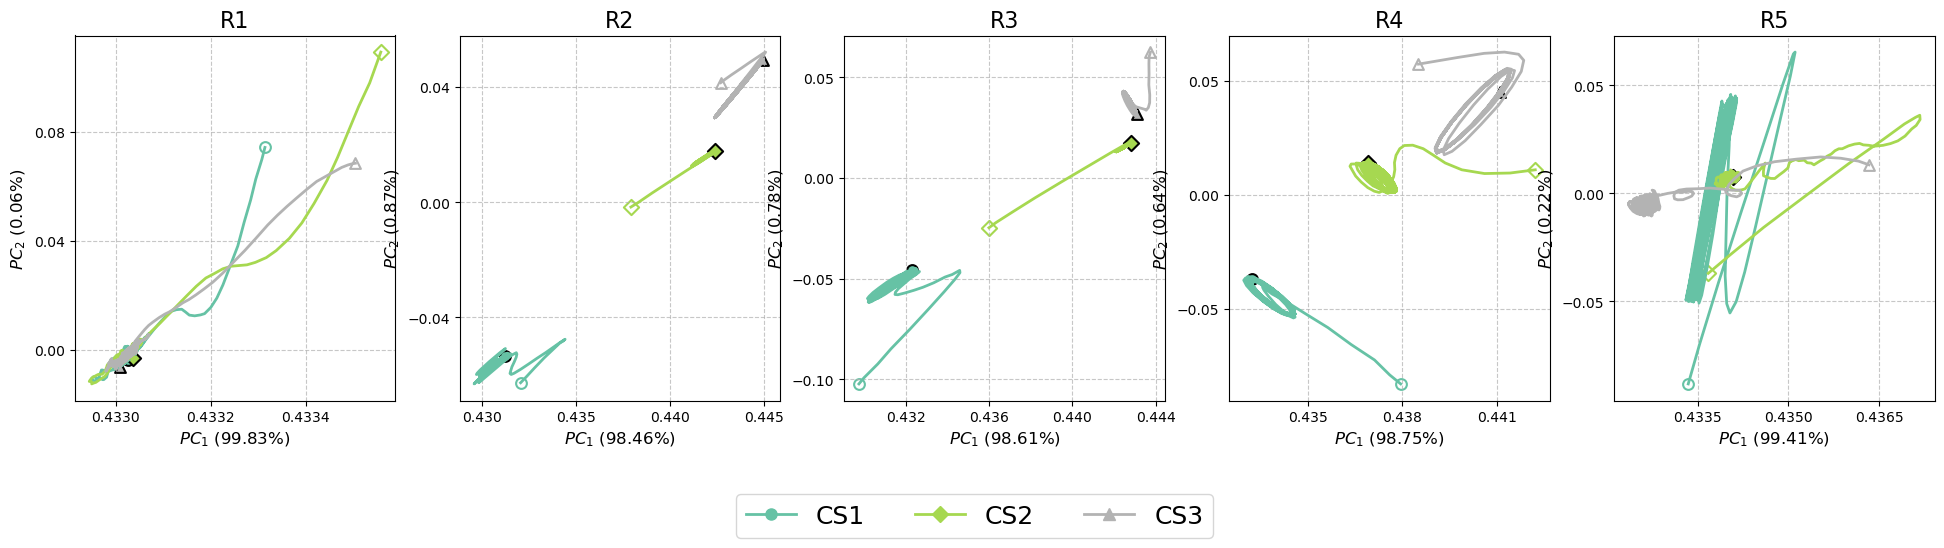

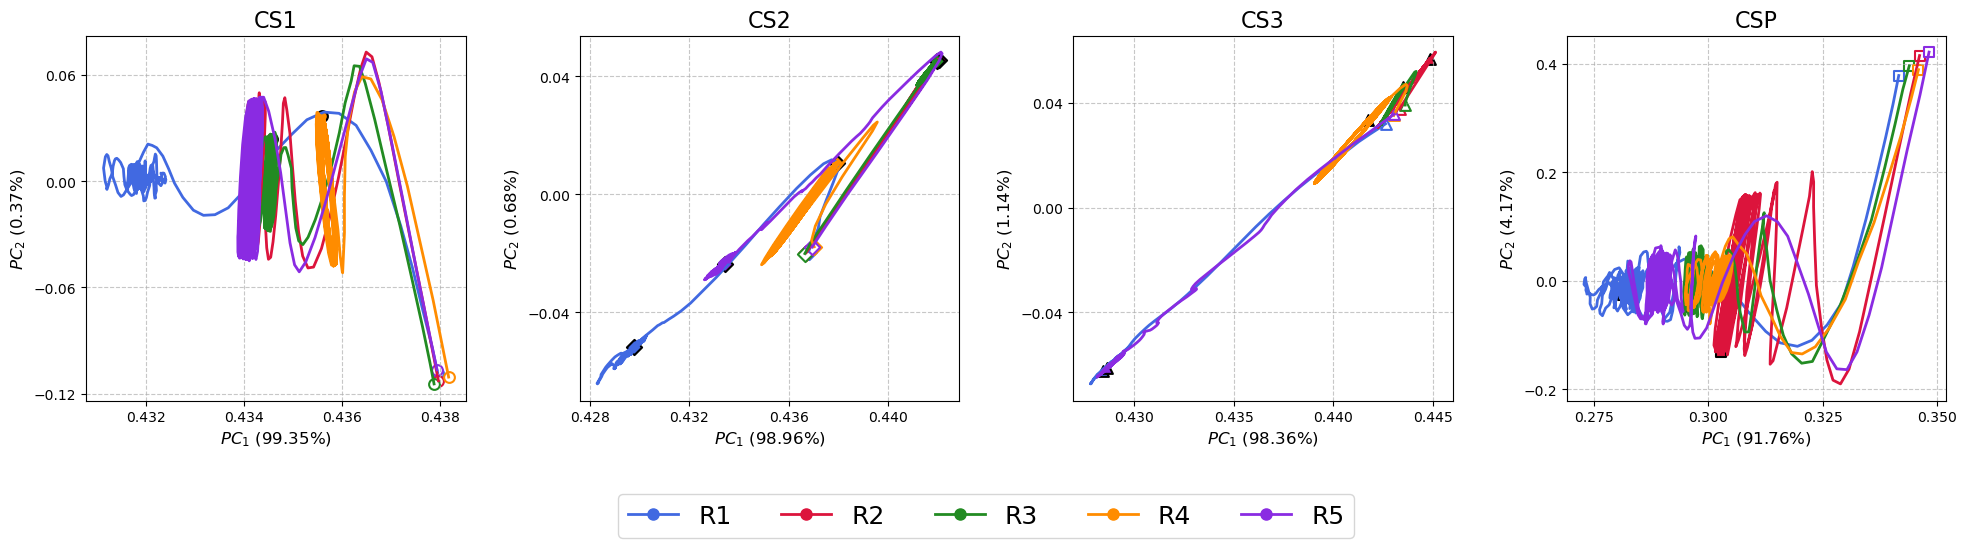

In [114]:
def plot_uncentered_pca_comparison_2d(data_dict, rules, ics, n_components=2, structure='time_first'):
    """
    Create comprehensive visualization with uncentered PCA in 2D:
    - First figure: Uncentered PCA across ICs for each rule (all rules in one row)
    - Second figure: Uncentered PCA across rules for each IC (all ICs in one row)
    
    Args:
        data_dict: Dictionary with structure rule -> ic -> single trajectory
        rules: List of rules to compare
        ics: List of IC indices to analyze
        n_components: Number of PCA components (default 2 for 2D visualization)
        structure: Data structure format ('time_first', 'trial_first', or 'qubit_first')
    """
    # Filter ICs for PCA per rule (only use CS1, CS2, CS3)
    ics_for_per_rule = [ic for ic in ics if ic in ['CS1', 'CS2', 'CS3']]
    
    # Map IC names to more descriptive labels
    ic_name_map = {'CS1': "CS1", 'CS2': "CS2", 'CS3': "CS3", 'CSP': "CSP"}
    
    # Specific colors for ICs and rules
    ic_colors = ["#66c2a5","#a6d850","#b3b3b3","#6B8FAD"]
    rule_colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']
    
    # Map colors to rules and ICs
    rule_color_map = {rule: rule_colors[i % len(rule_colors)] for i, rule in enumerate(rules)}
    ic_color_map = {ic: ic_colors[i % len(ic_colors)] for i, ic in enumerate(ics)}
    
    # Define marker shapes for ICs
    ic_marker_map = {'CS1': 'o', 'CS2': 'D', 'CS3': '^', 'CSP': 's'}
    
    # Preprocess data to ensure consistent format
    processed_dict = {}
    n_time_steps = None
    n_qubits = None
    
    for rule in rules:
        processed_dict[rule] = {}
        for ic in ics:
            if ic in data_dict.get(rule, {}):
                # Get the data (ensemble-averaged trajectory)
                data = np.array(data_dict[rule][ic])
                
                # Determine time steps and qubits if not already set
                if n_time_steps is None or n_qubits is None:
                    if structure == 'time_first':  # (time_steps, n_qubits)
                        n_time_steps = data.shape[0]
                        n_qubits = data.shape[1]
                    elif structure == 'qubit_first':  # (n_qubits, time_steps)
                        n_qubits = data.shape[0]
                        n_time_steps = data.shape[1]
                    else:  # trial_first
                        n_time_steps = data.shape[1]
                        n_qubits = data.shape[2]  
                
                # Process according to structure
                if structure == 'qubit_first':  # (n_qubits, time_steps)
                    processed_dict[rule][ic] = data.T
                elif structure == 'time_first':  # Already (time_steps, features)
                    processed_dict[rule][ic] = data
                else:  # trial_first, squeeze out singleton dimension
                    processed_dict[rule][ic] = np.squeeze(data)
    
    # Function to compute uncentered PCA
    def uncentered_pca(data, n_components=2):
        # Compute uncentered second moment matrix
        sigma = (1/data.shape[0]) * data.T @ data
        
        # Compute eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        
        # Sort by decreasing eigenvalue
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top components
        components = eigenvectors[:, :n_components]
        
        # Project data onto components
        projections = data @ components
        
        # Calculate explained variance ratio
        explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
        
        return projections, components, explained_variance_ratio
    
    # ---- FIRST FIGURE: Uncentered PCA across ICs for each rule (all in one row) ----
    fig_pca_by_rule = plt.figure(figsize=(24, 5))
    gs_pca_by_rule = gridspec.GridSpec(1, len(rules))
    gs_pca_by_rule.update(wspace=0.2, hspace=0.2)
    
    # Create custom legend elements for this figure
    legend_elements_by_rule = []
    
    for r_idx, rule in enumerate(rules):
        ax = fig_pca_by_rule.add_subplot(gs_pca_by_rule[0, r_idx])
        
        # Get all ICs for this rule (only the specified ones for per-rule plot)
        available_ics = [ic for ic in ics_for_per_rule if ic in processed_dict[rule]]
        
        if not available_ics:
            ax.text(0.5, 0.5, f"No data for rule {rule}", 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(f"Rule: {rule}")
            continue
        
        # Combine data from all ICs for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for ic in available_ics])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by IC
        ic_projections = {}
        start_idx = 0
        for ic in available_ics:
            ic_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + ic_data_size
            ic_projections[ic] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each IC trajectory
        for ic in available_ics:
            proj = ic_projections[ic]
            color = ic_color_map[ic]
            marker = ic_marker_map[ic]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], '-', 
                   linewidth=1, color=color, label=f'{ic_name_map[ic]}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], 
                      color='white', marker=marker, s=60, edgecolors=color, linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], 
                      color=color, marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once)
            if r_idx == 0:
                legend_elements_by_rule.append(Line2D([0], [0], color=color, marker=marker, 
                                             linestyle='-', linewidth=1, markersize=8,
                                             label=f'{ic_name_map[ic]}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f' ({explained_variance_ratio[0]:.2%})',fontsize=12)
        ax.set_ylabel(r'$PC_2$'f' ({explained_variance_ratio[1]:.2%})',fontsize=12)
        ax.set_title(f'{rule}',fontsize=16)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    # Add a single legend for all subplots
    fig_pca_by_rule.legend(handles=legend_elements_by_rule, loc='lower center', 
                         bbox_to_anchor=(0.5, -0.15), ncol=len(ics_for_per_rule), fontsize=18)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make space for the legend
    plt.savefig('uncentered_pca_all_ics_per_rule_2d.png', dpi=300, bbox_inches='tight')
    
    # ---- SECOND FIGURE: Uncentered PCA across rules for each IC (all in one row) ----
    # Use the specific ICs: CS1, CS2, CS3, CSP
    specific_ics = ['CS1', 'CS2', 'CS3', 'CSP']
    available_specific_ics = [ic for ic in specific_ics if ic in ics]
    
    fig_pca_by_ic = plt.figure(figsize=(24, 5))
    gs_pca_by_ic = gridspec.GridSpec(1, len(available_specific_ics))
    gs_pca_by_ic.update(wspace=0.3, hspace=0.4)
    
    # Create custom legend elements for this figure
    legend_elements_by_ic = []
    
    for ic_idx, ic in enumerate(available_specific_ics):
        marker = ic_marker_map[ic]
        ax = fig_pca_by_ic.add_subplot(gs_pca_by_ic[0, ic_idx])
        
        # Get all rules that have this IC
        available_rules = [rule for rule in rules if ic in processed_dict.get(rule, {})]
        
        if not available_rules:
            ax.text(0.5, 0.5, f"No data for IC {ic_name_map[ic]}", 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(f"IC: {ic_name_map[ic]}")
            continue
        
        # Combine data from all rules for PCA fitting
        combined_data = np.vstack([processed_dict[rule][ic] for rule in available_rules])
        
        # Perform uncentered PCA
        combined_projections, _, explained_variance_ratio = uncentered_pca(combined_data, n_components)
        
        # Split projections back by rule
        rule_projections = {}
        start_idx = 0
        for rule in available_rules:
            rule_data_size = processed_dict[rule][ic].shape[0]
            end_idx = start_idx + rule_data_size
            rule_projections[rule] = combined_projections[start_idx:end_idx]
            start_idx = end_idx
        
        # Plot each rule trajectory
        for rule in available_rules:
            proj = rule_projections[rule]
            color = rule_color_map[rule]
            
            # Plot trajectory
            ax.plot(proj[:, 0], proj[:, 1], '-', 
                   linewidth=1, color=color, label=f'Rule {rule}')
            
            # Add markers for start (unfilled) and end (filled) points
            ax.scatter(proj[0, 0], proj[0, 1], 
                      color='white', marker=marker, s=60, edgecolors=color, linewidth=1.5)
            ax.scatter(proj[-1, 0], proj[-1, 1], 
                      color=color, marker=marker, s=60, edgecolors='black', linewidth=1.5)
            
            # Add to legend elements (only once per rule)
            if ic_idx == 0 and rule not in [elem.get_label().split()[-1] for elem in legend_elements_by_ic]:
                legend_elements_by_ic.append(Line2D([0], [0], color=color, marker='o', 
                                             linestyle='-', linewidth=1, markersize=8,
                                             label=f'{rule}'))
        
        # Set labels and title
        ax.set_xlabel(r'$PC_1$'f' ({explained_variance_ratio[0]:.2%})',fontsize=12)
        ax.set_ylabel(r'$PC_2$'f' ({explained_variance_ratio[1]:.2%})',fontsize=12)
        ax.set_title(f'{ic_name_map[ic]}',fontsize=16)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    
    # Add a single legend for all subplots
    fig_pca_by_ic.legend(handles=legend_elements_by_ic, loc='lower center', 
                        bbox_to_anchor=(0.5, -0.15), ncol=len(rules), fontsize=18)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make space for the legend
    plt.savefig('uncentered_pca_all_rules_per_ic_2d.png', dpi=300, bbox_inches='tight')
    
    return fig_pca_by_rule, fig_pca_by_ic

N=12
reference_p = ((N-1) * 0.1 + 0.4) / N
fig, fig_entropy = plot_uncentered_pca_comparison_2d(
     data_ens_avg, 
     rules=['R1', 'R2', 'R3','R4','R5'], 
     ics=['CS1', 'CS2', 'CS3','CSP'])